<a href="https://colab.research.google.com/github/NutraSmart/Chicago-COVID-Hospitalizations/blob/main/Region_11_Chicago_Forecast_Covid_Hospitalizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Objective

Explore ability of different models to predict daily covid hospitalizations for Chicago

In [ ]:
# install, then restart runtime environment
!pip install numpy --upgrade

In [ ]:
# we want 1.21.5
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
np.__version__

'1.21.5'

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import tensorflow as tf
from tensorflow.keras import layers

import IPython
import IPython.display

!pip install sodapy
import sodapy
from sodapy import Socrata

In [ ]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       612 non-null    datetime64[ns]
 1   RegionID                   612 non-null    int64         
 2   RegionDescription          612 non-null    object        
 3   TotalTests                 612 non-null    int64         
 4   PositiveTests              612 non-null    int64         
 5   TestPositivity_RollingAvg  612 non-null    float64       
 6   MedSurgAvailPct_Avg        612 non-null    object        
 7   ICUAvailPct_Avg            612 non-null    object        
 8   cli_admits                 612 non-null    int64         
 9   covid_beds_in_use          612 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 47.9+ KB


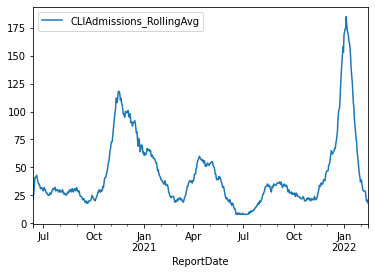

In [ ]:
# Region 11 (Chicago )
# COVID-19 Regional Metrics (Test Positivity, Hospital Availability, & CLI Admissions)
# CLI Admissions is a 7-day rolling average

# Visits are defined as CLI if the patient presents with a fever AND either cough, 
# difficulty breathing or is given a diagnosis of COVID-19.

# Source:
# https://dph.illinois.gov/covid19/data/data-portal/test-positivity-hospital-availability-cli-admissions.html

csv_endpoint='https://idph.illinois.gov/DPHPublicInformation/api/COVIDExport/GetResurgenceData?format=csv&regionID=11&daysIncluded=0'

chicago_covid=pd.read_csv(csv_endpoint,skiprows=1)

chicago_covid['ReportDate']=pd.to_datetime(chicago_covid['ReportDate'])
chicago_covid.plot(y='CLIAdmissions_RollingAvg',x='ReportDate')

chicago_covid.rename(columns={'ReportDate':'date','CLIAdmissions_RollingAvg':'cli_admits',\
                                  'COVIDHospitalBedsInUse':'covid_beds_in_use'},inplace=True)

# smooth covid_beds_in_use (this might be smoothed already)
#region_11_metrics['covid_beds_in_use']=region_11_metrics['covid_beds_in_use'].rolling(7).mean()

cols_to_keep=['date','cli_admits','covid_beds_in_use']
chicago_covid.info()

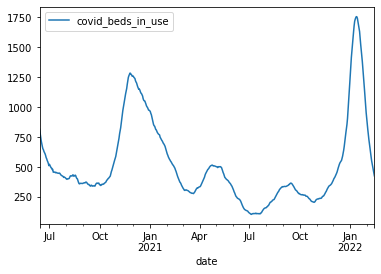

In [ ]:
chicago_covid.plot(y='covid_beds_in_use',x='date')

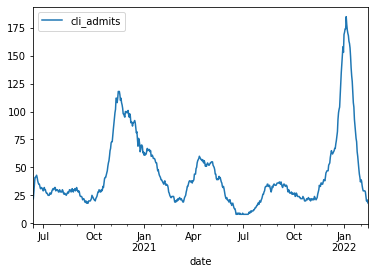

In [ ]:
chicago_covid.plot(y='cli_admits',x='date')

In [ ]:
chicago_covid.columns

Index(['date', 'RegionID', 'RegionDescription', 'TotalTests', 'PositiveTests',
       'TestPositivity_RollingAvg', 'MedSurgAvailPct_Avg', 'ICUAvailPct_Avg',
       'cli_admits', 'covid_beds_in_use'],
      dtype='object')

In [ ]:
cols_to_keep=['date','cli_admits','covid_beds_in_use']

In [ ]:
chicago_covid.tail()

,date,RegionID,RegionDescription,TotalTests,PositiveTests,TestPositivity_RollingAvg,MedSurgAvailPct_Avg,ICUAvailPct_Avg,cli_admits,covid_beds_in_use
607,2022-02-10,11,Chicago,45818,839,2.3,13.00 %,15.00 %,24,527
608,2022-02-11,11,Chicago,36395,548,2.2,12.00 %,15.00 %,20,498
609,2022-02-12,11,Chicago,23571,412,2.1,11.00 %,15.00 %,21,474
610,2022-02-13,11,Chicago,18228,544,2.0,11.00 %,15.00 %,19,450
611,2022-02-14,11,Chicago,19773,544,2.0,11.00 %,15.00 %,18,427


In [ ]:
cols_to_keep

['date', 'cli_admits', 'covid_beds_in_use']

In [ ]:
cols_to_keep

['date', 'cli_admits', 'covid_beds_in_use']

In [ ]:
chicago_covid=chicago_covid[cols_to_keep]
chicago_covid.tail()

,date,cli_admits,covid_beds_in_use
607,2022-02-10,24,527
608,2022-02-11,20,498
609,2022-02-12,21,474
610,2022-02-13,19,450
611,2022-02-14,18,427


In [ ]:
chicago_covid.head()

,date,cli_admits,covid_beds_in_use
0,2020-06-13,22,816
1,2020-06-14,28,784
2,2020-06-15,35,748
3,2020-06-16,41,719
4,2020-06-17,41,695


In [ ]:
chicago_covid.sort_values(by=['date'],ascending=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


#### Split Dataset Train/Val/Test

In [ ]:
# train on the most recent 200 days of data
days_for_train=200
train_df=chicago_covid[-days_for_train:]

# try to validate on the 120 days before that
days_for_val=120
val_df=chicago_covid[-days_for_val-days_for_train:-days_for_train]

# test on earlier time period
test_df=chicago_covid[:-days_for_val-days_for_train]

print('train dates: ')
print(train_df['date'].min(),train_df['date'].max())

print('validation dates: ')
print(val_df['date'].min(),val_df['date'].max())

print('test dates: ')
print(test_df['date'].min(),test_df['date'].max())

print('training observations: ')
print(train_df['date'].count())

train dates: 
2021-07-30 00:00:00 2022-02-14 00:00:00
validation dates: 
2021-04-01 00:00:00 2021-07-29 00:00:00
test dates: 
2020-06-13 00:00:00 2021-03-31 00:00:00
training observations: 
200


In [ ]:
chicago_covid.set_index(['date'],inplace=True)

In [ ]:
train_df.set_index(['date'],inplace=True)
val_df.set_index(['date'],inplace=True)
test_df.set_index(['date'],inplace=True)
#omicron_df.set_index(['date'],inplace=True)

In [ ]:
# create column indices and num_features
column_indices = {name: i for i, name in enumerate(train_df.columns)}
num_features = train_df.shape[1]
num_features


2

In [ ]:
column_indices

{'cli_admits': 0, 'covid_beds_in_use': 1}

In [ ]:
#normalize the datasets
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df-train_mean)/train_std
val_df = (val_df-train_mean)/train_std
test_df = (test_df-train_mean)/train_std



In [ ]:
train_std

cli_admits            42.701841
covid_beds_in_use    445.416258
dtype: float64

In [ ]:
train_mean

cli_admits            51.200
covid_beds_in_use    540.175
dtype: float64

In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cli_admits,200.0,-2.586820e-16,1.0,-0.800902,-0.619411,-0.402793,0.188516,3.133354
covid_beds_in_use,200.0,1.171285e-16,1.0,-0.853527,-0.635754,-0.453901,0.172479,2.727393


In [ ]:
hosp_range=[train_df['covid_beds_in_use'].min(),train_df['covid_beds_in_use'].max()]
hosp_range

[-0.8535274441870581, 2.7273925886356096]

#### Training Windows

In [ ]:
class WindowGenerator():

  # this class creates windows using train_df, val_df, and test_df
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  # this method operates on WindowGenerator
  # Given a list of consecutive inputs, the split_window method will convert them to 
  # a window of inputs and a window of labels.
  
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
chicago_covid.columns

Index(['cli_admits', 'covid_beds_in_use'], dtype='object')

In [ ]:
def plot(self, model=None, plot_col='covid_beds_in_use', max_subplots=3):
  # this plot method shows the window and. if a model!=None
  # shows predicted values
  
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    plt.ylim(hosp_range)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('day')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  # make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset
  # of (input_window, label_window) pairs 
  # using the preprocessing.timeseries_dataset_from_array function

  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
# properties for accessing training, validation and test data of the WindowGenerator class

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
def set_max_epochs(x):
  # define a global variable for MAX_EPOCHS
  # in model fitting
  global MAX_EPOCHS
  MAX_EPOCHS=x


In [ ]:
# create a custom loss function
# since the context is hospitalizations for the week
# we want model-predicted hospitlizations for the week
# to be close to actual hospitalizations for the week
# we don't need to calculate daily error or difference between actual and predicted

def week_loss_abs_diff(y_true, y_pred):
    # difference between predicted hospitalizations for the week (output window)
    # and actual hospitalizations for the week 
    diff_of_sums = tf.reduce_sum(y_true)-tf.reduce_sum(y_pred)
    squared_diff=tf.square(diff_of_sums)
    abs_diff=tf.abs(diff_of_sums)

    #return tf.reduce_mean(abs_diff)
    return abs_diff

In [ ]:
#

def week_loss_sq_diff(y_true, y_pred):
    # difference between predicted hospitalizations for the week (output window)
    # and actual hospitalizations for the week 
    diff_of_sums = tf.reduce_sum(y_true)-tf.reduce_sum(y_pred)
    squared_diff=tf.square(diff_of_sums)
    abs_diff=tf.abs(diff_of_sums)

    return tf.reduce_mean(squared_diff) 

In [ ]:

def compile_and_fit(model, window, patience=2):
  # This function: 1. creates a model
  # 2. returns results of validation

# this had been set to monitor val_loss
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.SGD(),\
                metrics=[tf.metrics.MeanAbsoluteError(),week_loss_abs_diff])
  
  #model.compile(loss=week_loss_abs_diff,optimizer=tf.optimizers.Adam(),\
   #             metrics=[tf.metrics.MeanAbsoluteError(),week_loss_abs_diff])

  #model.compile(loss=week_loss_b,optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanAbsoluteError(),week_loss_b])
  #model.compile(loss=week_loss_sq_diff,optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanAbsoluteError(),week_loss_sq_diff, week_loss_abs_diff])


  # use custom loss function
  #model.compile(loss=week_loss_b,optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanAbsoluteError(),week_loss_fn, week_loss_b])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val)
                      #callbacks=[early_stopping])
  return history

### Models
Output 14 days of outputs

#### Linear Model
labels are a linear combination of the inputs

In [ ]:
chicago_covid.columns

Index(['cli_admits', 'covid_beds_in_use'], dtype='object')

In [ ]:
# for linear model, this should be symmetric where output days = input days
CONV_WIDTH = 14
conv_window_10 = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=14,
    shift=14)

conv_window_10

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Label column name(s): None

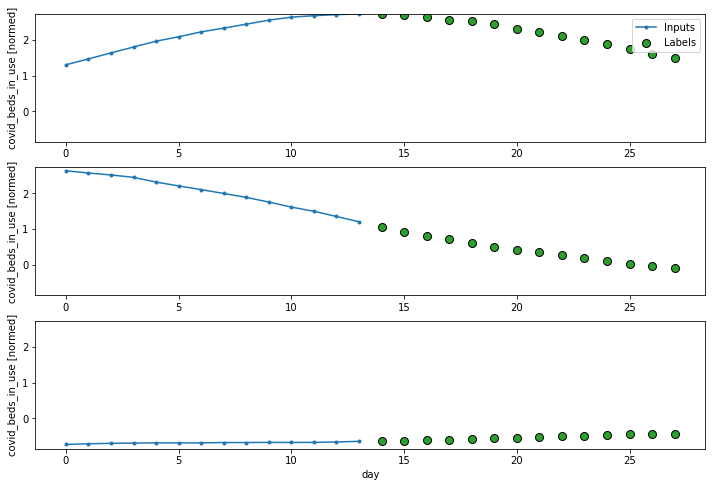

In [ ]:
conv_window_10.plot()

In [ ]:
# a linear model that takes as input the entire input window
# 
#num_labels=1
#OUT_STEPS=10
OUT_STEPS=14

num_features=2

# this was derived from multi-linear model
linear_model = tf.keras.Sequential([

    #tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # flatten because we have multiple days of inputs
    tf.keras.layers.Flatten(),

    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
                  
    # Shape => [batch, out_steps, features]
    #tf.keras.layers.Reshape([OUT_STEPS, num_features])
    tf.keras.layers.Reshape([OUT_STEPS, num_features])

])

In [ ]:
# check shapes
print('Input shape (batch, time, inputs):', conv_window_10.example[0].shape)
print('Output shape (batch, time, labels):', linear_model(conv_window_10.example[0]).shape)

Input shape (batch, time, inputs): (32, 14, 2)
Output shape (batch, time, labels): (32, 14, 2)


In [ ]:
set_max_epochs(100)


In [ ]:
linear_hist = compile_and_fit(linear_model, conv_window_10)

Epoch 1/100
6/6 [==============================] - 2s 70ms/step - loss: 1.0413 - mean_absolute_error: 0.7597 - week_loss_abs_diff: 168.6200 - val_loss: 0.4191 - val_mean_absolute_error: 0.5520 - val_week_loss_abs_diff: 470.7491
Epoch 2/100
6/6 [==============================] - 0s 21ms/step - loss: 0.9291 - mean_absolute_error: 0.7109 - week_loss_abs_diff: 143.5318 - val_loss: 0.3711 - val_mean_absolute_error: 0.5212 - val_week_loss_abs_diff: 444.0704
Epoch 3/100
6/6 [==============================] - 0s 21ms/step - loss: 0.8377 - mean_absolute_error: 0.6675 - week_loss_abs_diff: 110.5713 - val_loss: 0.3287 - val_mean_absolute_error: 0.4919 - val_week_loss_abs_diff: 418.6356
Epoch 4/100
6/6 [==============================] - 0s 23ms/step - loss: 0.7601 - mean_absolute_error: 0.6275 - week_loss_abs_diff: 84.7830 - val_loss: 0.2941 - val_mean_absolute_error: 0.4660 - val_week_loss_abs_diff: 396.2719
Epoch 5/100
6/6 [==============================] - 0s 21ms/step - loss: 0.6986 - mean_abs

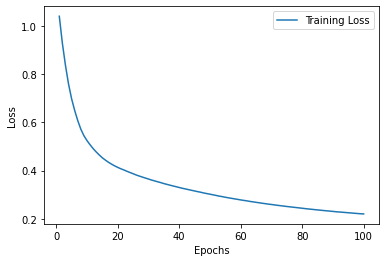

In [ ]:

loss_values = linear_hist.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# initialize
val_performance = {}
performance = {}

3/3 [==============================] - 0s 4ms/step - loss: 0.0825 - mean_absolute_error: 0.2370 - week_loss_abs_diff: 203.1773


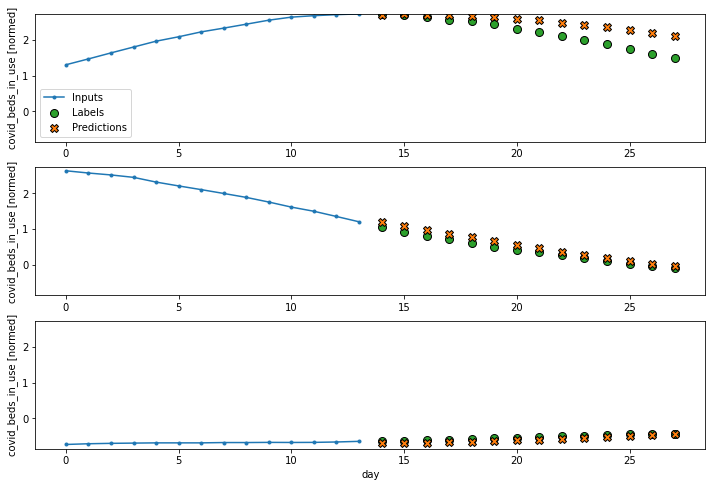

In [ ]:

IPython.display.clear_output()
val_performance['Linear'] = linear_model.evaluate(conv_window_10.val)
performance['Linear'] = linear_model.evaluate(conv_window_10.test, verbose=0)
conv_window_10.plot(linear_model)

#### Multi-Step Dense
now that we created hospitalizations_next7, we can create a multi-step dense model
which uses 10 days of inputs to produce one prediction

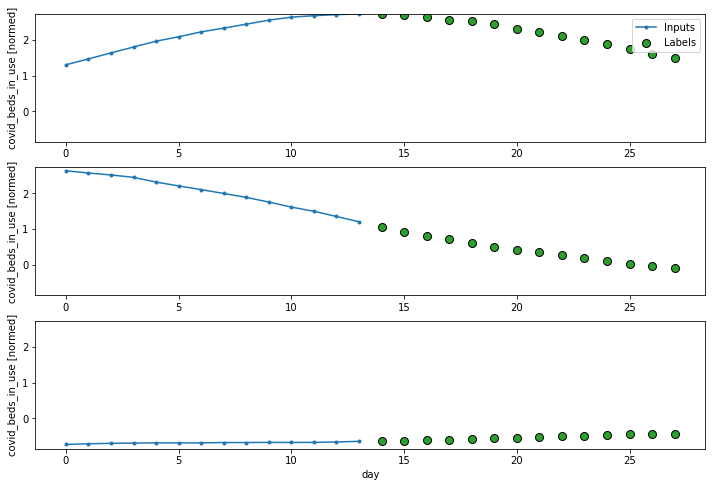

In [ ]:
conv_window_10.plot()

In [ ]:
OUT_STEPS,num_features

(14, 2)

In [ ]:

multi_dense_model = tf.keras.Sequential([

    # (batch, time, features)
    #tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Flatten(),

    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
OUT_STEPS,num_features

(14, 2)

In [ ]:
print('Input shape:', conv_window_10.example[0].shape)
print('Output shape:', multi_dense_model(conv_window_10.example[0]).shape)

Input shape: (32, 14, 2)
Output shape: (32, 14, 2)


In [ ]:
# 
set_max_epochs(150)

In [ ]:
dense_hist = compile_and_fit(multi_dense_model, conv_window_10)


Epoch 1/150
6/6 [==============================] - 1s 51ms/step - loss: 1.0814 - mean_absolute_error: 0.7785 - week_loss_abs_diff: 107.4466 - val_loss: 0.4782 - val_mean_absolute_error: 0.5873 - val_week_loss_abs_diff: 501.5670
Epoch 2/150
6/6 [==============================] - 0s 13ms/step - loss: 1.0622 - mean_absolute_error: 0.7733 - week_loss_abs_diff: 92.3456 - val_loss: 0.4798 - val_mean_absolute_error: 0.5885 - val_week_loss_abs_diff: 502.7936
Epoch 3/150
6/6 [==============================] - 0s 23ms/step - loss: 1.0407 - mean_absolute_error: 0.7682 - week_loss_abs_diff: 74.3319 - val_loss: 0.4801 - val_mean_absolute_error: 0.5889 - val_week_loss_abs_diff: 503.2544
Epoch 4/150
6/6 [==============================] - 0s 13ms/step - loss: 1.0210 - mean_absolute_error: 0.7625 - week_loss_abs_diff: 101.5187 - val_loss: 0.4804 - val_mean_absolute_error: 0.5892 - val_week_loss_abs_diff: 503.6818
Epoch 5/150
6/6 [==============================] - 0s 14ms/step - loss: 1.0014 - mean_abso

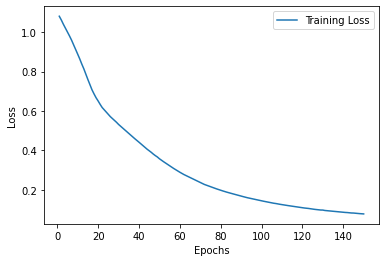

In [ ]:
loss_values = dense_hist.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
val_performance['Multi dense'] = multi_dense_model.evaluate(conv_window_10.val)
performance['Multi dense'] = multi_dense_model.evaluate(conv_window_10.test, verbose=0)

3/3 [==============================] - 0s 5ms/step - loss: 0.0841 - mean_absolute_error: 0.2449 - week_loss_abs_diff: 212.0553


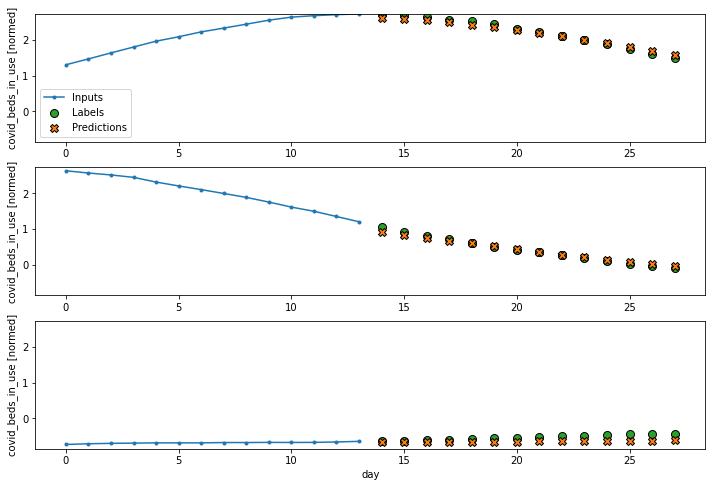

In [ ]:
conv_window_10.plot(multi_dense_model)

#### CNN

In [ ]:
CONV_WIDTH

14

In [ ]:
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    # i think this takes that last 7 days of inputs
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),

    # Shape => [batch, 1, conv_units]
    #tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),

    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])


In [ ]:
set_max_epochs(150)

In [ ]:
cnn_hist = compile_and_fit(multi_conv_model, conv_window_10)


Epoch 1/150
6/6 [==============================] - 1s 80ms/step - loss: 1.0864 - mean_absolute_error: 0.7796 - week_loss_abs_diff: 81.0334 - val_loss: 0.4765 - val_mean_absolute_error: 0.5862 - val_week_loss_abs_diff: 500.4973
Epoch 2/150
6/6 [==============================] - 0s 29ms/step - loss: 1.0797 - mean_absolute_error: 0.7776 - week_loss_abs_diff: 82.4916 - val_loss: 0.4757 - val_mean_absolute_error: 0.5858 - val_week_loss_abs_diff: 500.2622
Epoch 3/150
6/6 [==============================] - 0s 28ms/step - loss: 1.0734 - mean_absolute_error: 0.7757 - week_loss_abs_diff: 144.4911 - val_loss: 0.4746 - val_mean_absolute_error: 0.5852 - val_week_loss_abs_diff: 499.7956
Epoch 4/150
6/6 [==============================] - 0s 31ms/step - loss: 1.0675 - mean_absolute_error: 0.7738 - week_loss_abs_diff: 205.3381 - val_loss: 0.4735 - val_mean_absolute_error: 0.5846 - val_week_loss_abs_diff: 499.3005
Epoch 5/150
6/6 [==============================] - 0s 32ms/step - loss: 1.0609 - mean_abso

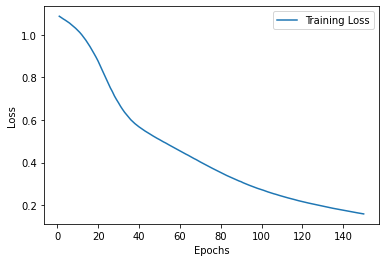

In [ ]:
loss_values = cnn_hist.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

3/3 [==============================] - 0s 4ms/step - loss: 0.0819 - mean_absolute_error: 0.2542 - week_loss_abs_diff: 220.6024


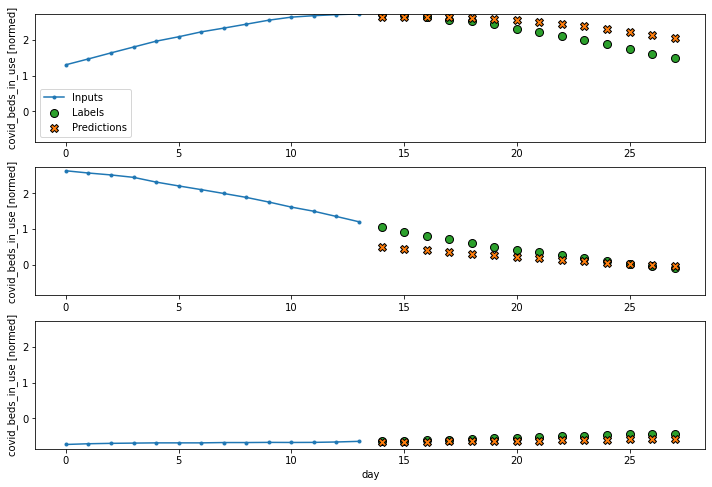

In [ ]:

val_performance['Conv'] = multi_conv_model.evaluate(conv_window_10.val)
performance['Conv'] = multi_conv_model.evaluate(conv_window_10.test, verbose=0)
conv_window_10.plot(multi_conv_model)

In [ ]:
val_performance['Conv'] = multi_conv_model.evaluate(conv_window_14.val)
performance['Conv'] = multi_conv_model.evaluate(conv_window_14.test, verbose=0)

NameError: ignored

#### LSTM

In [ ]:
num_features

2

In [ ]:
# derived from multi_lstm_model

OUT_STEPS=14

num_features=train_df.shape[1]

lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(128, return_sequences=False),
    #tf.keras.layers.LSTM(7, return_sequences=False),


    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
# ( batch, time, features)
print('Input shape:', conv_window_10.example[0].shape)

# ( batch, time, fautures)
print('Output shape:', lstm_model(conv_window_10.example[0]).shape)

Input shape: (32, 14, 2)
Output shape: (32, 14, 2)


In [ ]:
# val error stops improving after 4 epochs
set_max_epochs(150)

In [ ]:
# use the same conv_window we created for earlier models
lstm_hist = compile_and_fit(lstm_model, conv_window_10)


Epoch 1/150
6/6 [==============================] - 3s 131ms/step - loss: 1.0869 - mean_absolute_error: 0.7796 - week_loss_abs_diff: 92.9927 - val_loss: 0.4752 - val_mean_absolute_error: 0.5854 - val_week_loss_abs_diff: 499.7995
Epoch 2/150
6/6 [==============================] - 0s 39ms/step - loss: 1.0818 - mean_absolute_error: 0.7777 - week_loss_abs_diff: 108.6903 - val_loss: 0.4733 - val_mean_absolute_error: 0.5843 - val_week_loss_abs_diff: 498.9518
Epoch 3/150
6/6 [==============================] - 0s 30ms/step - loss: 1.0769 - mean_absolute_error: 0.7759 - week_loss_abs_diff: 108.9432 - val_loss: 0.4714 - val_mean_absolute_error: 0.5833 - val_week_loss_abs_diff: 498.0807
Epoch 4/150
6/6 [==============================] - 0s 29ms/step - loss: 1.0723 - mean_absolute_error: 0.7741 - week_loss_abs_diff: 125.1732 - val_loss: 0.4695 - val_mean_absolute_error: 0.5822 - val_week_loss_abs_diff: 497.1662
Epoch 5/150
6/6 [==============================] - 0s 31ms/step - loss: 1.0676 - mean_ab

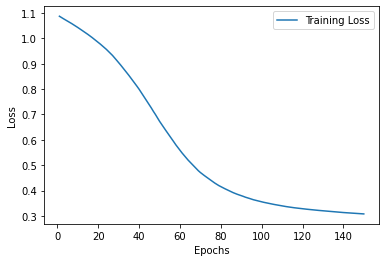

In [ ]:
loss_values = lstm_hist.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:

val_performance['LSTM'] = lstm_model.evaluate(conv_window_10.val)
performance['LSTM'] = lstm_model.evaluate(conv_window_10.test, verbose=0)

3/3 [==============================] - 0s 6ms/step - loss: 0.1925 - mean_absolute_error: 0.3922 - week_loss_abs_diff: 340.2652


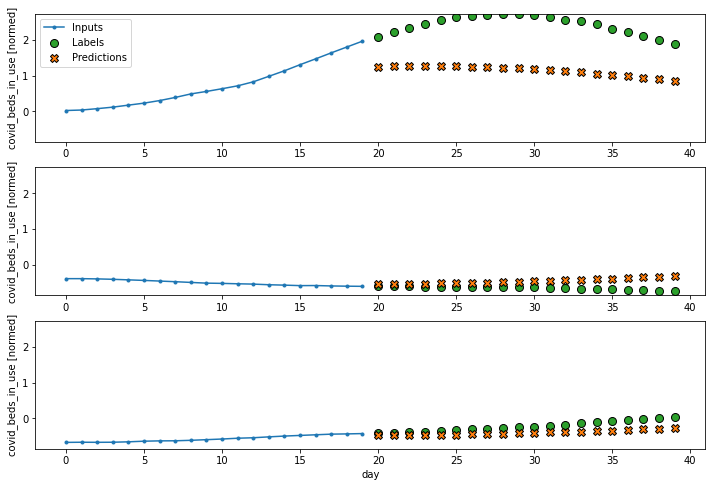

In [ ]:
conv_window_10.plot(lstm_model)

#### Performance



In [ ]:
column_indices

{'cli_admits': 0, 'covid_beds_in_use': 1}

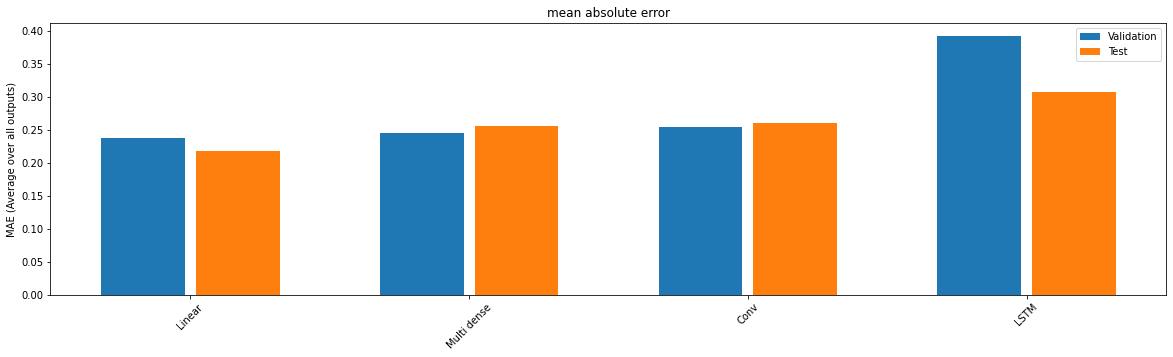

In [ ]:
# this is error for all the variables!

# after 40 epochs, train error is zero for all models

plt.figure(figsize=(20,5))

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = linear_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('MAE (Average over all outputs)')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.title('mean absolute error')

# range for val
#plt.ylim(0.1,0.3)

# range for test
#plt.ylim(0,0.25)
_ = plt.legend()

In [ ]:
train_df.tail(10)

,cases_total,hospitalizations_total
date,,
2021-12-17,2.645403,2.058796
2021-12-18,2.661755,2.250018
2021-12-19,2.683557,2.406472
2021-12-20,2.653579,2.667228
2021-12-21,2.653579,2.987090
2021-12-22,2.806196,3.035764
2021-12-23,2.748965,3.303474
2021-12-24,2.686282,3.578138
2021-12-25,2.645403,3.598998


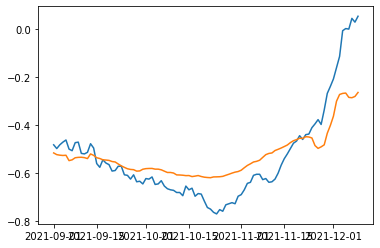

In [ ]:
plt.plot(train_df['hospitalizations_total'][:100])
plt.plot(train_df['cases_total'][:100])

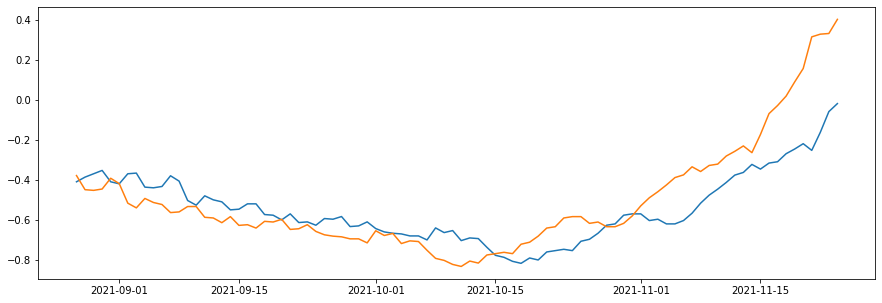

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(val_df['hospitalizations_total'])
plt.plot(val_df['cases_total'])

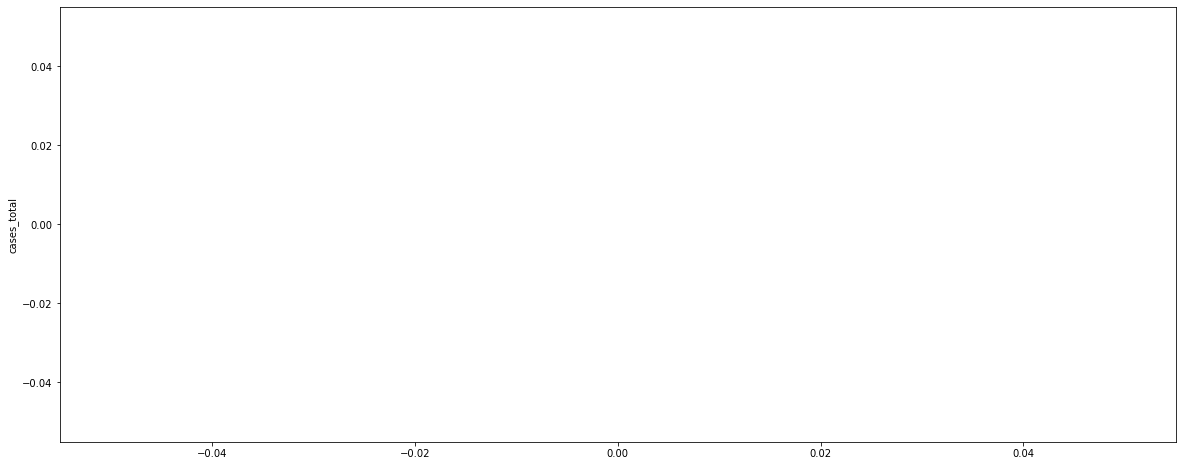

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=val_df,y='cases_total',estimator='sum')

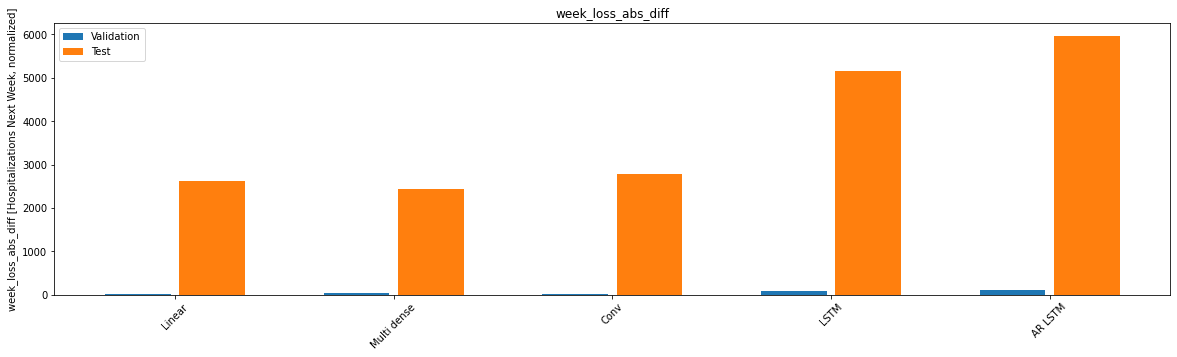

In [ ]:
# week loss b

plt.figure(figsize=(20,5))

x = np.arange(len(performance))
width = 0.3
metric_name = 'week_loss_abs_diff'
metric_index = lstm_model.metrics_names.index('week_loss_abs_diff')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('week_loss_abs_diff [Hospitalizations Next Week, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.title('week_loss_abs_diff')
#plt.ylim(0,4000)
_ = plt.legend()

In [ ]:
# week_loss_sq_diff
plt.figure(figsize=(20,5))

x = np.arange(len(performance))
width = 0.3
metric_name = 'week_loss_sq_diff'
metric_index = lstm_model.metrics_names.index('week_loss_sq_diff')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('week_loss_sq_diff [Hospitalizations Next Week, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
#plt.ylim(0,60)
plt.title('week_loss_sq_diff')
_ = plt.legend()

ValueError: ignored

<Figure size 1440x360 with 0 Axes>

In [ ]:
lstm_model.metrics_names

['loss', 'mean_absolute_error', 'week_loss_sq_diff', 'week_loss_abs_diff']

### Actuals vs Predicted

In [ ]:
column_indices

{'cli_admits': 0, 'covid_beds_in_use': 1}

In [ ]:
def inputs_only(input_df,window_shape):
  # converts dataframe to sliding window (array) for input into the models
  temp_array=np.array(input_df)
  return sliding_window_view(temp_array,window_shape)


In [ ]:
def plot_validation(dataset,actuals_col_name,predicted,model,input_width):
  # model parameter not used

  plt.figure(figsize=(20,8))
  plt.plot(predicted,label='predicted')
  plt.plot

  # to align actuals with predicted, shift actuals, omitting 'input_width' records
  if dataset=='train':
    plt.plot(train_df[actuals_col_name][input_width:].values,label='actuals')
    plt.title('predicted train')
  elif dataset=='val':
    plt.plot(val_df[actuals_col_name][input_width:].values,label='actuals')
    plt.title('predicted val')
  else:
    plt.plot(test_df[actuals_col_name][input_width:].values,label='actuals')
    plt.title('predicted test')
  plt.legend(loc='upper left')

In [ ]:
def df_to_ds(input_df):
  ds=tfdf.keras.pd_dataframe_to_tf_dataset(input_df)
  return ds

In [ ]:
# create sliding windows for input into model

# input window is 14 days wide

window_width=14
num_features=2

test_inputs=inputs_only(conv_window_10.test_df,(window_width,num_features))
val_inputs=inputs_only(conv_window_10.val_df,(window_width,num_features))
train_inputs=inputs_only(conv_window_10.train_df,(window_width,num_features))

In [ ]:
last_test_window=inputs_only(conv_window_10.test_df[-14:],(window_width,2))

In [ ]:
input_shapes=train_inputs.shape,val_inputs.shape,test_inputs.shape
input_shapes

((187, 1, 14, 2), (107, 1, 14, 2), (279, 1, 14, 2))

In [ ]:
def predicted_from_model(inputs,model,reshaped_dims):
  reshaped_inputs=inputs.reshape(reshaped_dims)
  predicted=model.predict(reshaped_inputs)
  return predicted

#### Linear Model

In [ ]:
input_shapes

((187, 1, 14, 2), (107, 1, 14, 2), (279, 1, 14, 2))

In [ ]:
predicted_from_linear_train=predicted_from_model(train_inputs,linear_model,(187,2,14))
predicted_from_linear_val=predicted_from_model(val_inputs,linear_model,(107,2,14))
predicted_from_linear_test=predicted_from_model(test_inputs,linear_model,(279,2,14))


predicted_from_linear_train.shape

(187, 14, 2)

In [ ]:
column_indices

{'cli_admits': 0, 'covid_beds_in_use': 1}

In [ ]:
train_df.tail()

,cli_admits,covid_beds_in_use
date,,
2022-02-06,-0.518244,0.278714
2022-02-07,-0.518244,0.191780
2022-02-08,-0.518244,0.115991
2022-02-09,-0.541641,0.040202
2022-02-10,-0.635229,-0.015526


In [ ]:
predicted_from_linear_train.shape

(187, 14, 2)

In [ ]:
train_df.shape

(200, 2)

In [ ]:
column_indices

{'cli_admits': 0, 'covid_beds_in_use': 1}

In [ ]:
CONV_WIDTH

14

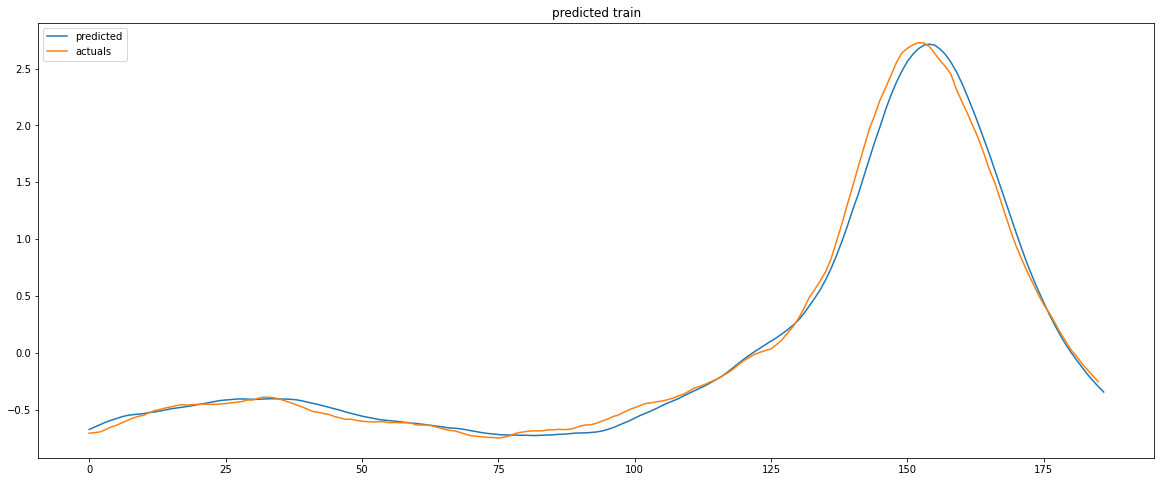

In [ ]:
# prediction 0, was generally lower than actual when beds were rising, end slightly higher than actual when falling

plot_validation('train','covid_beds_in_use',predicted_from_linear_train[:,0,1],linear_model, CONV_WIDTH)

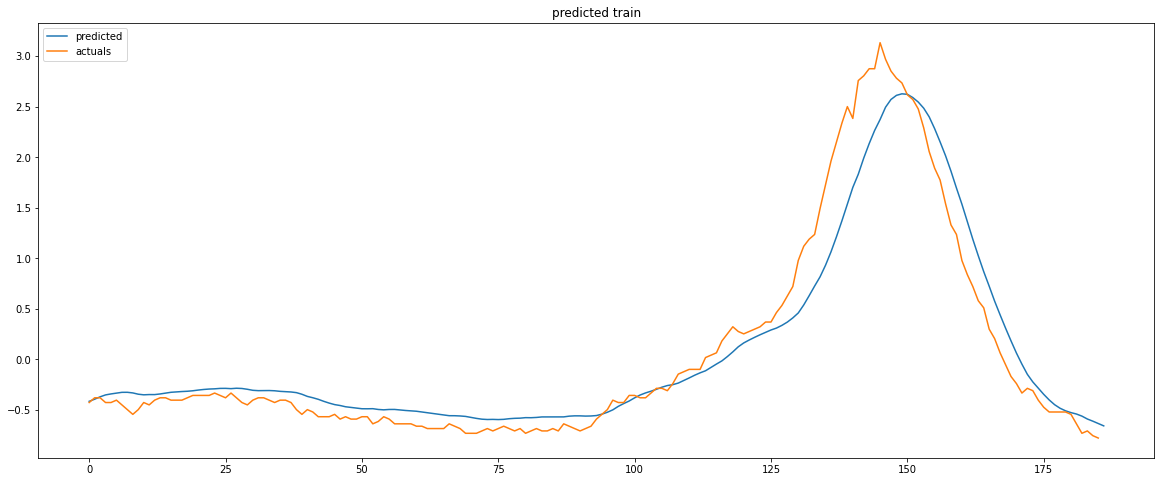

In [ ]:
plot_validation('train','cli_admits',predicted_from_linear_train[:,0,0],linear_model, CONV_WIDTH)

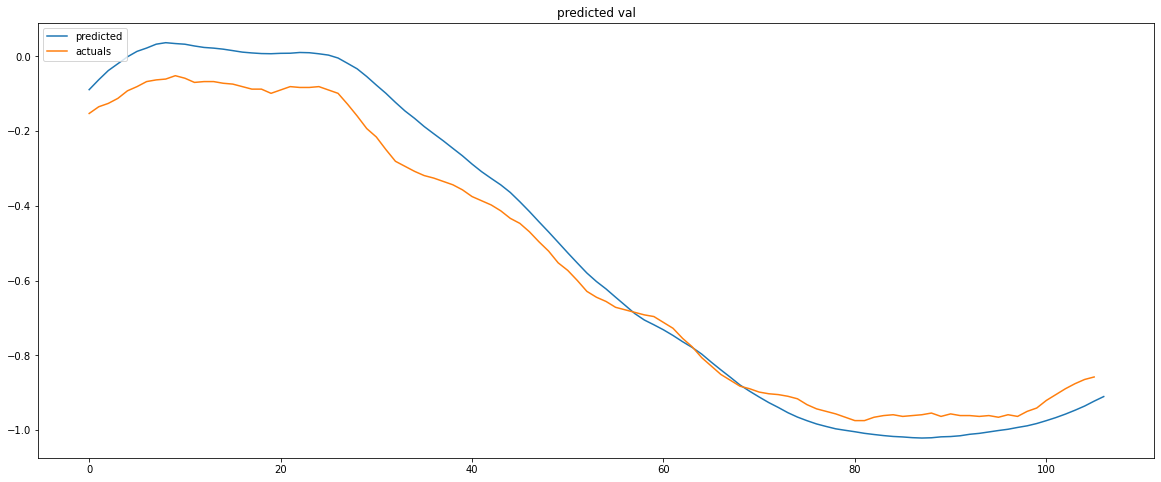

In [ ]:
# in validation data, predicted peak hospitalizations are slightly higher than actual peak hospitalizations
plot_validation('val','covid_beds_in_use',predicted_from_linear_val[:,0,1],linear_model, CONV_WIDTH)
#plt.ylim(-1,3)

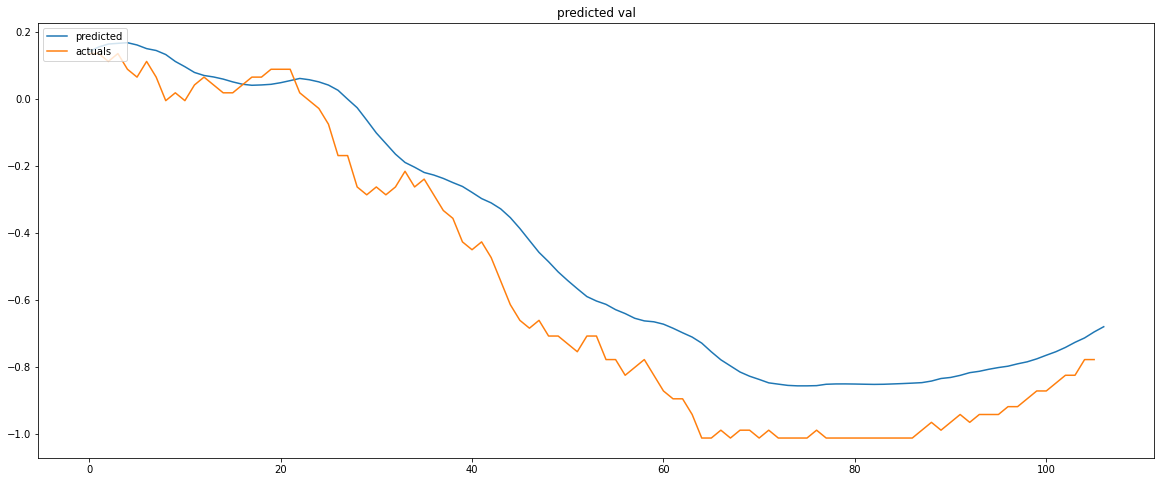

In [ ]:
# in validation data, predicted peak hospitalizations are slightly higher than actual peak hospitalizations
plot_validation('val','cli_admits',predicted_from_linear_val[:,0,0],linear_model, CONV_WIDTH)
#plt.ylim(-1,3)

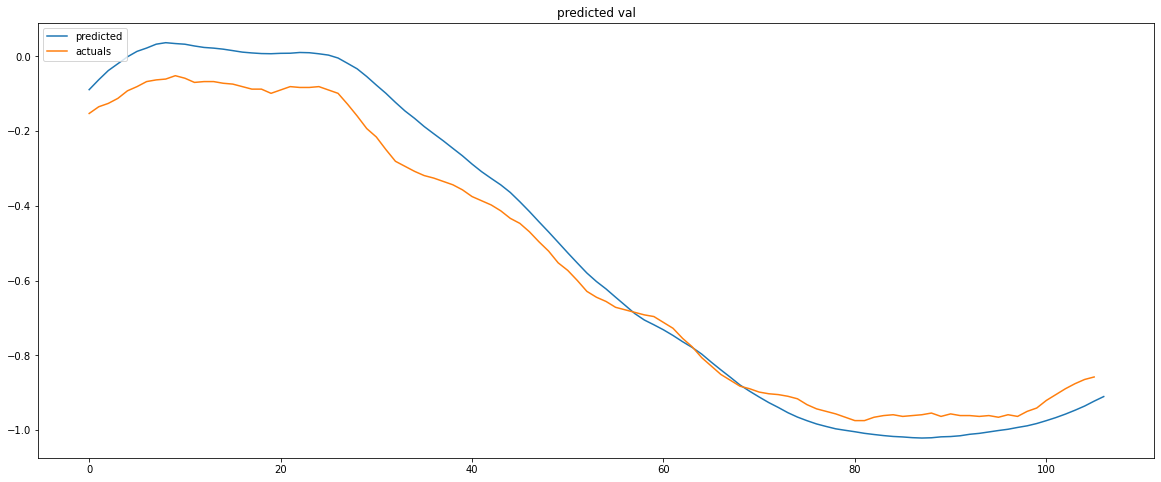

In [ ]:
plot_validation('val','covid_beds_in_use',predicted_from_linear_val[:,0,1],linear_model, CONV_WIDTH)
#plt.ylim(-1,3)

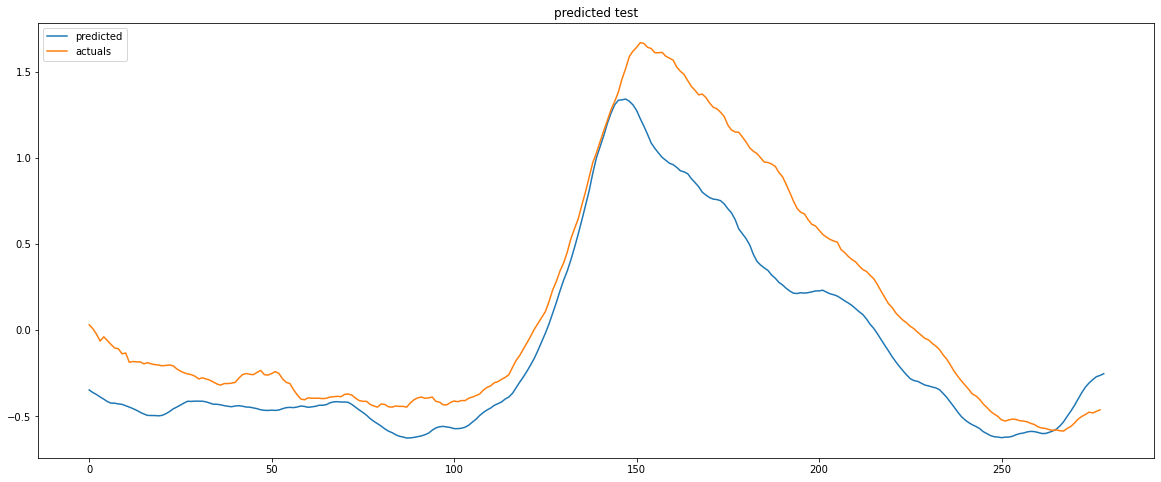

In [ ]:
# in the test dataset, predicted hospitalizations tend to be higher than actual
# due to omicron
plot_validation('test','covid_beds_in_use',predicted_from_linear_test[:,0,0],linear_model, CONV_WIDTH)
#plt.ylim(-1,3)

In [ ]:
input_shapes

((191, 2, 10, 1), (111, 2, 10, 1), (279, 2, 10, 1))

In [ ]:
predicted_from_rnl_train=predicted_from_model(train_inputs,resnet_linear,(191,10,2))
predicted_from_rnl_val=predicted_from_model(val_inputs,resnet_linear,(111,10,2))
predicted_from_rnl_test=predicted_from_model(test_inputs,resnet_linear,(279,10,2))

predicted_from_rnl_train.shape

(191, 10, 2)

In [ ]:
column_indices

{'cli_admits': 0, 'covid_beds_in_use': 1}

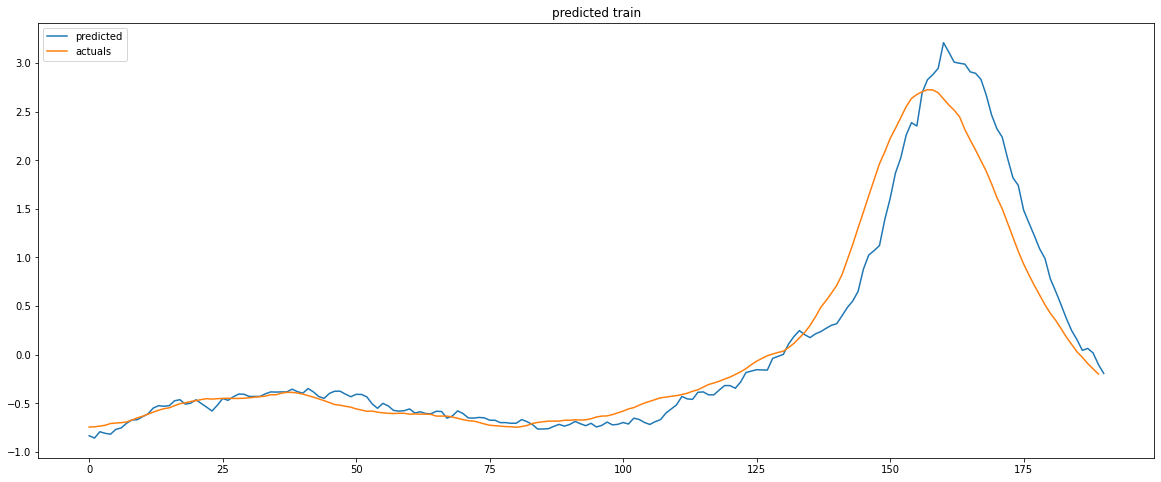

In [ ]:
# first value of output window is same as actuals
plot_validation('train','covid_beds_in_use',predicted_from_rnl_train[:,1,1],resnet_linear, CONV_WIDTH)

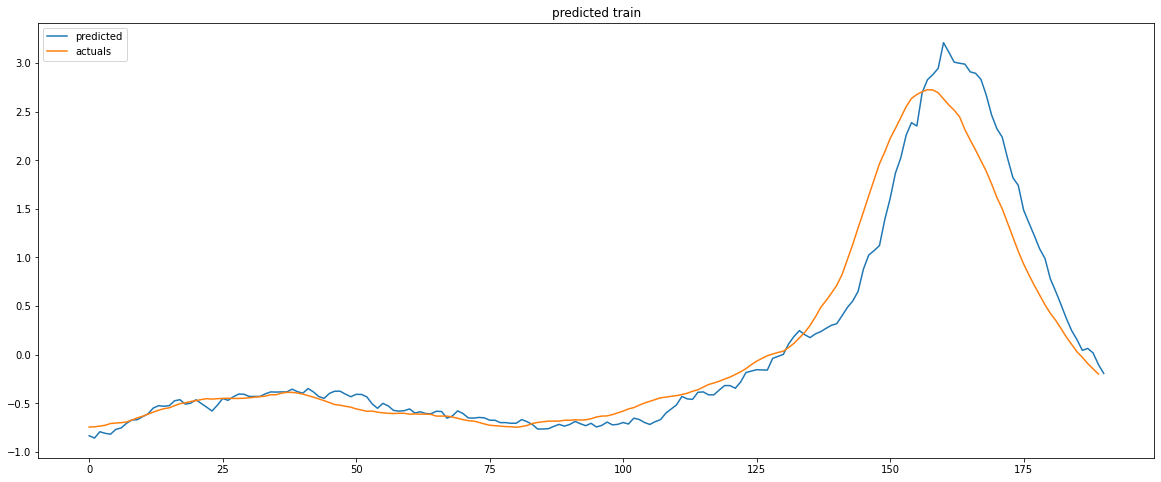

In [ ]:
# looking at second day of output window: 
# predicted has more variance than actual
plot_validation('train','covid_beds_in_use',predicted_from_rnl_train[:,1,1],resnet_linear, CONV_WIDTH)

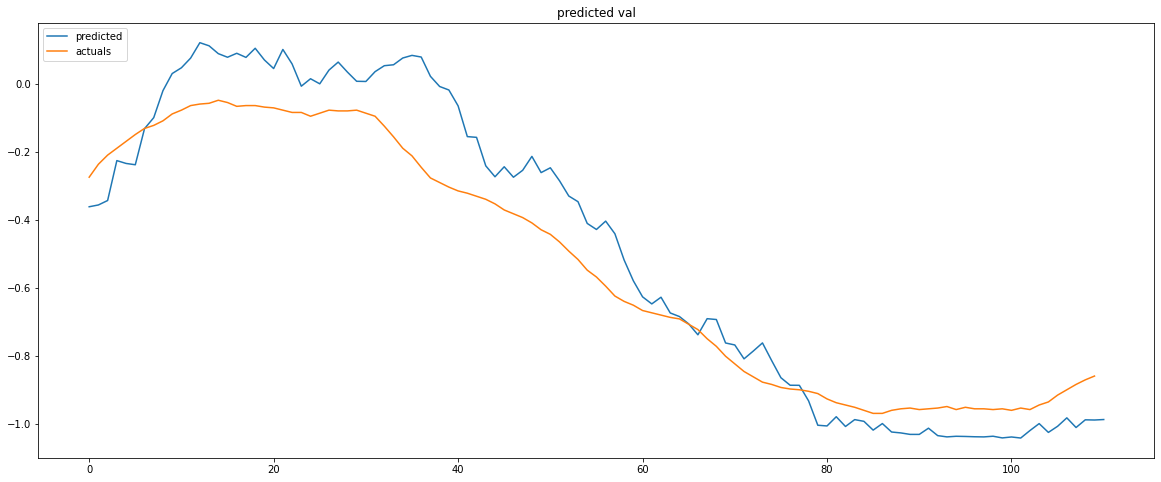

In [ ]:
plot_validation('val','covid_beds_in_use',predicted_from_rnl_val[:,1,1],resnet_linear, CONV_WIDTH)
#plt.ylim(-1,5)

(-1.0, 5.0)

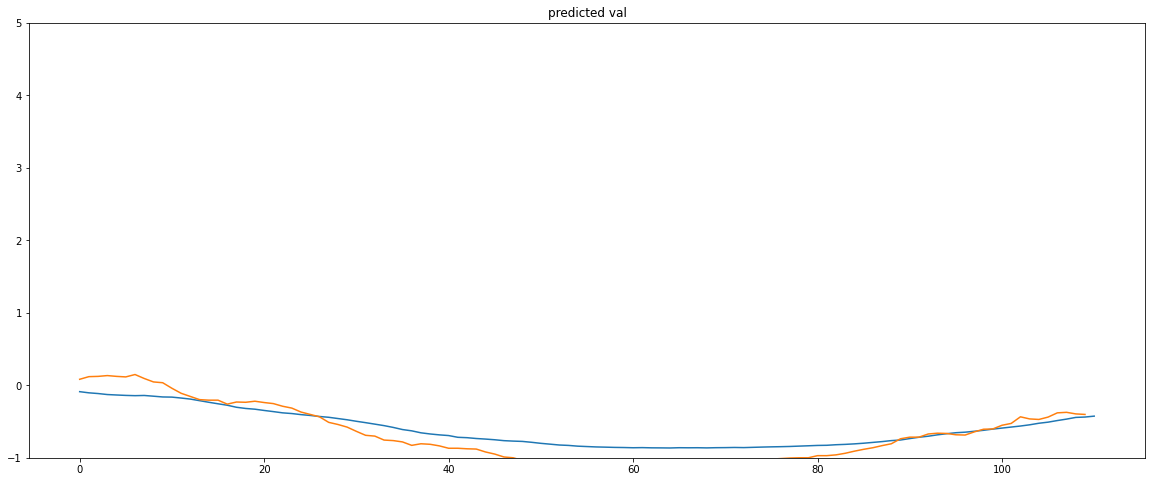

In [ ]:
plot_validation('val','hospitalizations_total',predicted_from_rnl_val[:,0,0],resnet_linear, CONV_WIDTH)
plt.ylim(-1,5)

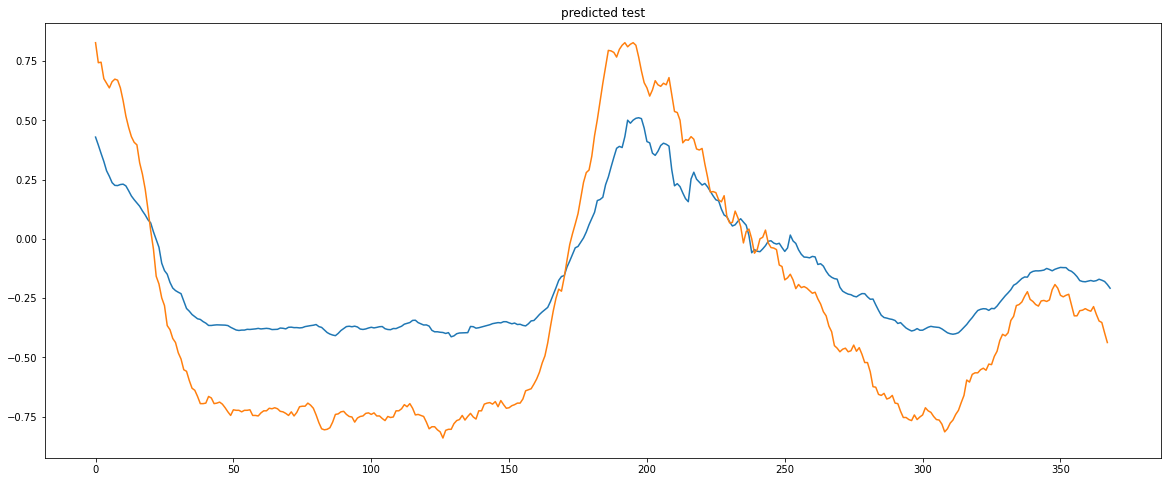

In [ ]:
# in the test dataset, predicted hospitalizations tend to be higher than actual
plot_validation('test','hospitalizations_total',predicted_from_rnl_test[:,1,0],resnet_linear, CONV_WIDTH)
#plt.ylim(-1,5)

(-1.0, 2.0)

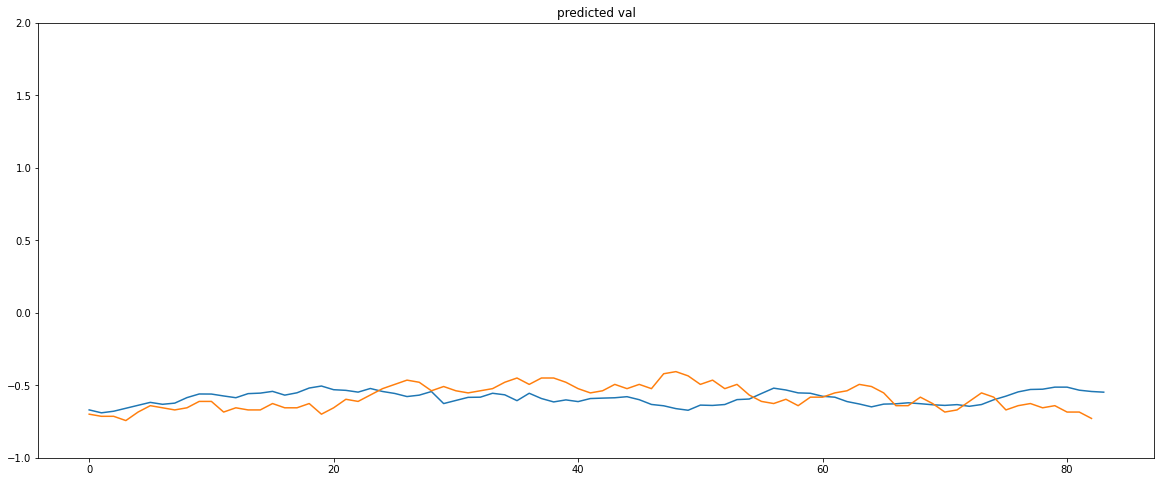

In [ ]:
# in the test dataset, predicted hospitalizations tend to be higher than actual
plot_validation('val','deaths_total',predicted_from_rnl_val[:,1,column_indices['deaths_total']],\
                resnet_linear, CONV_WIDTH)
plt.ylim(-1,2)

(-1.0, 5.0)

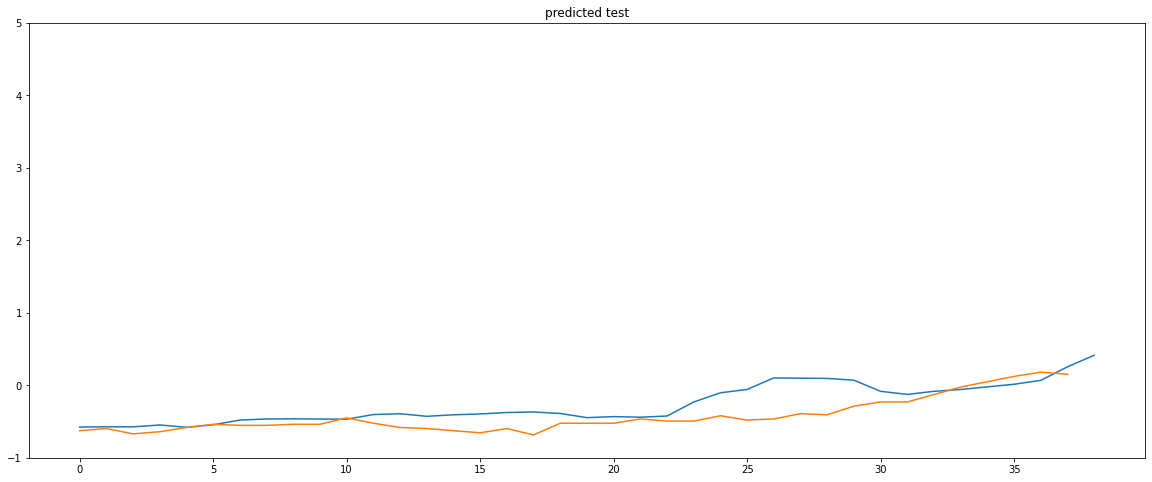

In [ ]:
# in the test dataset, predicted hospitalizations tend to be higher than actual
plot_validation('test','deaths_total',predicted_from_rnl_test[:,1,column_indices['deaths_total']],\
                resnet_linear, CONV_WIDTH)
plt.ylim(-1,5)

#### Multi-Step Dense

In [ ]:
input_shapes

((187, 1, 14, 2), (107, 1, 14, 2), (279, 1, 14, 2))

In [ ]:
predicted_from_msd_train=predicted_from_model(train_inputs,multi_dense_model,(187,2,14))
predicted_from_msd_val=predicted_from_model(val_inputs,multi_dense_model,(107,2,14))
predicted_from_msd_test=predicted_from_model(test_inputs,multi_dense_model,(279,2,14))

predicted_from_msd_train.shape

(187, 14, 2)

In [ ]:
train_inputs.shape

(187, 1, 14, 2)

In [ ]:
chicago_covid.columns

Index(['cli_admits', 'covid_beds_in_use'], dtype='object')

In [ ]:
CONV_WIDTH

14

In [ ]:
column_indices

{'cli_admits': 0, 'covid_beds_in_use': 1}

In [ ]:
predicted_from_msd_train.shape

(187, 14, 2)

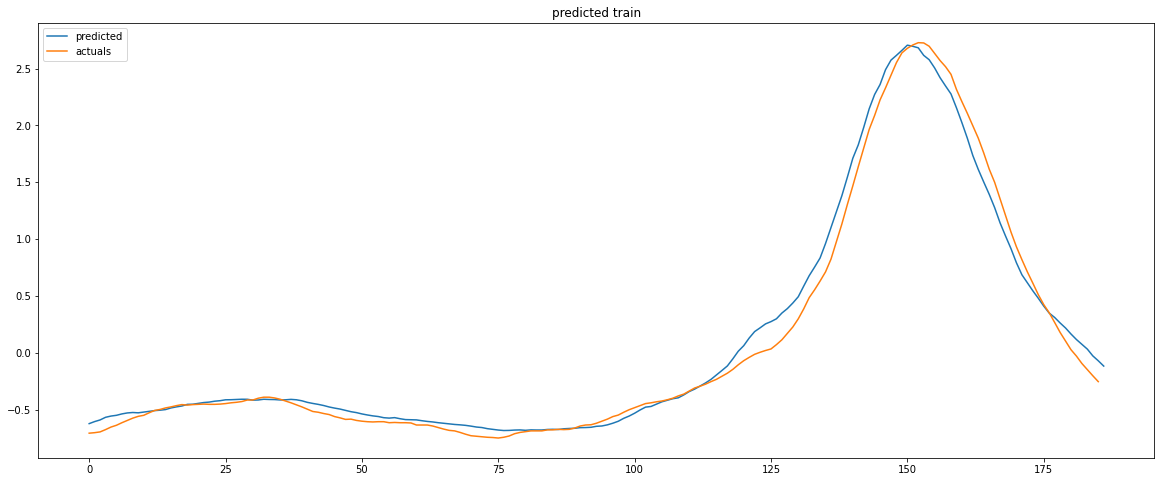

In [ ]:
plot_validation('train','covid_beds_in_use',predicted_from_msd_train[:,0,1],multi_dense_model, CONV_WIDTH)

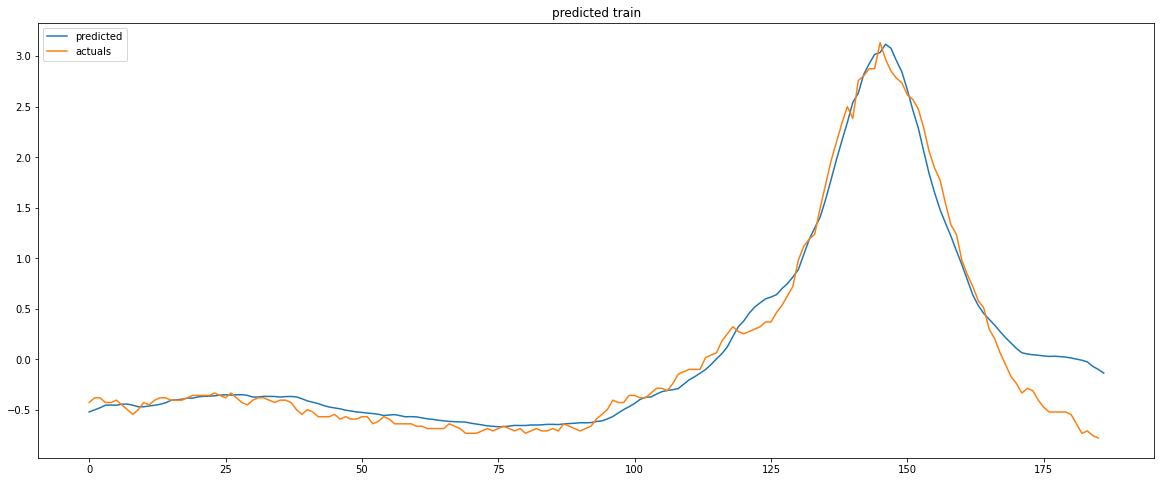

In [ ]:
# in validation data, predicted peak hospitalizations are slightly higher than actual peak hospitalizations
plot_validation('train','cli_admits',predicted_from_msd_train[:,0,0],multi_dense_model, CONV_WIDTH)
#plt.ylim(-1,3)

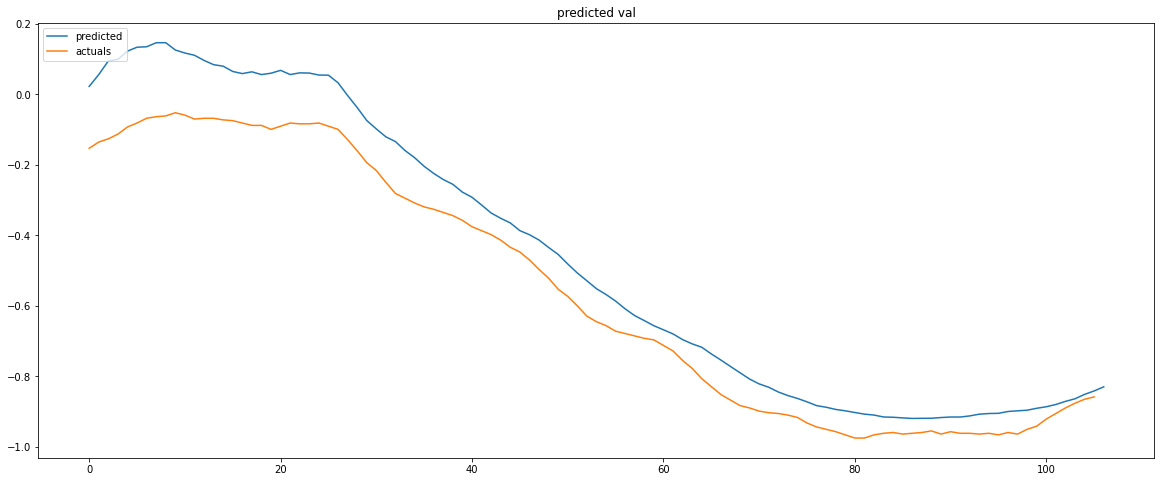

In [ ]:
plot_validation('val','covid_beds_in_use',predicted_from_msd_val[:,0,1],multi_dense_model, CONV_WIDTH)
#plt.ylim(-1,3)

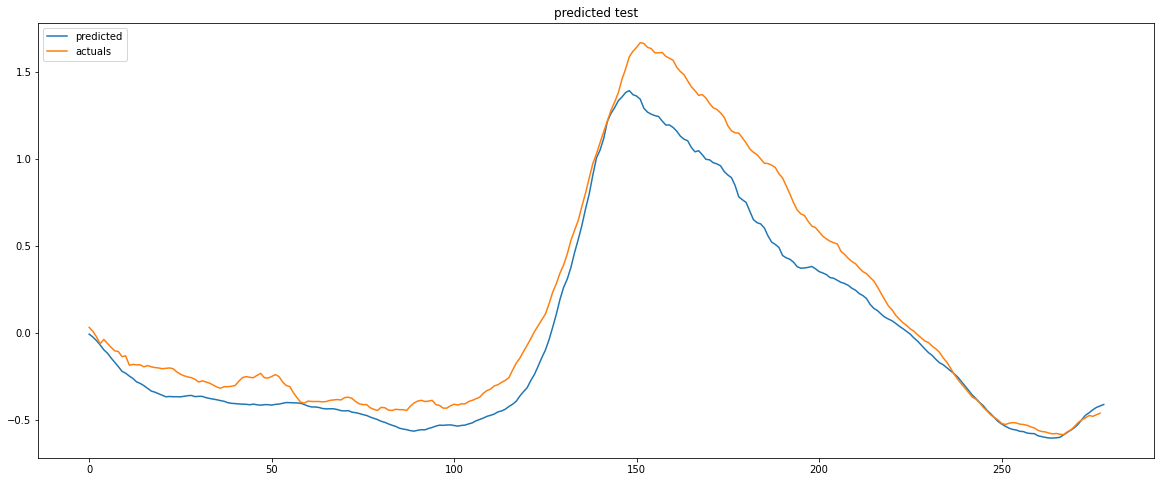

In [ ]:
plot_validation('test','covid_beds_in_use',predicted_from_msd_test[:,0,1],multi_dense_model, CONV_WIDTH)
#plt.ylim(-1,3)

#### CNN

In [ ]:
input_shapes

((187, 1, 14, 2), (107, 1, 14, 2), (279, 1, 14, 2))

In [ ]:
predicted_from_cnn_train=predicted_from_model(train_inputs,multi_conv_model,(187,14,2))
predicted_from_cnn_val=predicted_from_model(val_inputs,multi_conv_model,(107,14,2))
predicted_from_cnn_test=predicted_from_model(test_inputs,multi_conv_model,(279,14,2))

predicted_from_cnn_train.shape

(187, 14, 2)

In [ ]:
column_indices

{'cli_admits': 0, 'covid_beds_in_use': 1}

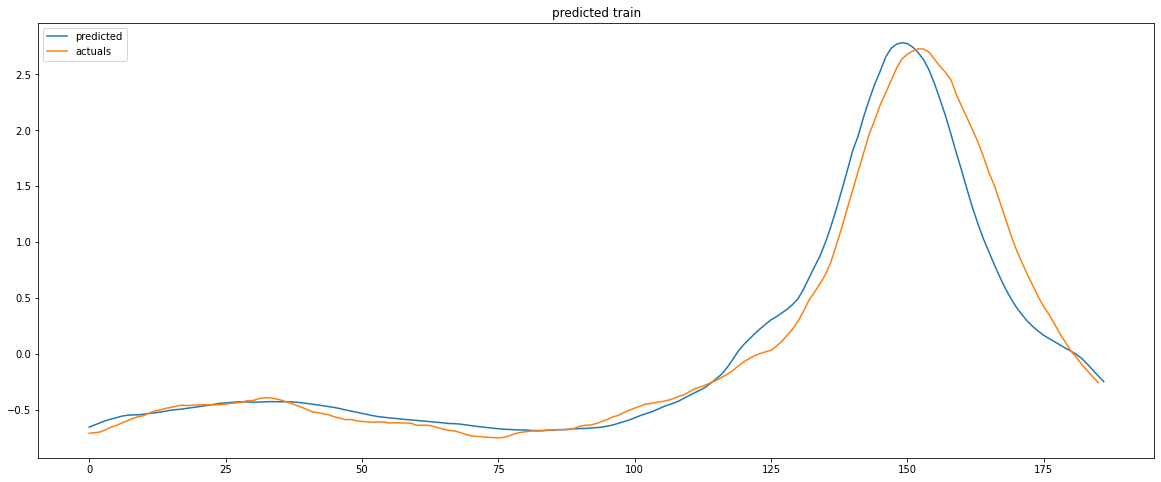

In [ ]:
# during the training period, predicted peak hospitalizations are slightly higher than actual, 
# when hospitalizations are rising
plot_validation('train','covid_beds_in_use',predicted_from_cnn_train[:,0,1],multi_conv_model,CONV_WIDTH)

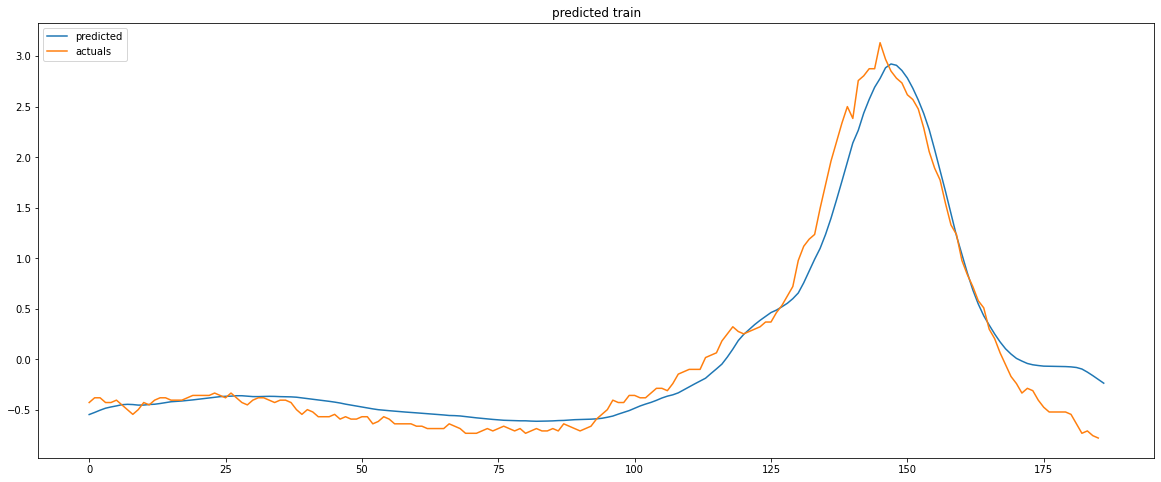

In [ ]:
plot_validation('train','cli_admits',predicted_from_cnn_train[:,0,0],multi_conv_model,CONV_WIDTH)

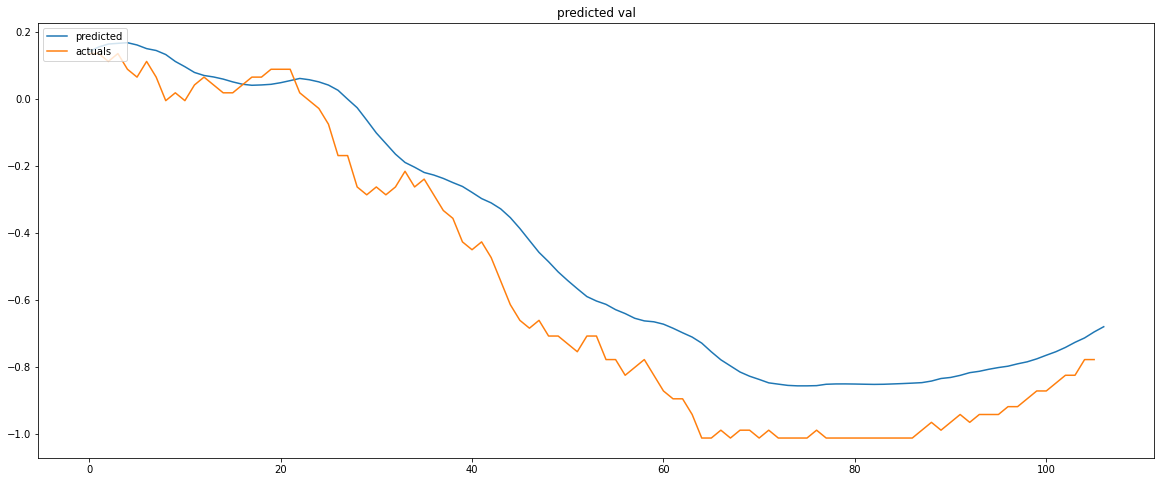

In [ ]:
# in validation data, predicted peak hospitalizations are slightly higher than actual peak hospitalizations
plot_validation('val','cli_admits',predicted_from_linear_val[:,0,0],linear_model, CONV_WIDTH)
#plt.ylim(-1,3)

In [ ]:
column_indices

{'cases_age_50_59': 2,
 'cases_age_60_69': 3,
 'cases_age_70_79': 4,
 'cases_black_non_latinx': 5,
 'cases_latinx': 6,
 'cases_total': 1,
 'cases_white_non_latinx': 7,
 'deaths_total': 8,
 'hospitalizations_total': 0}

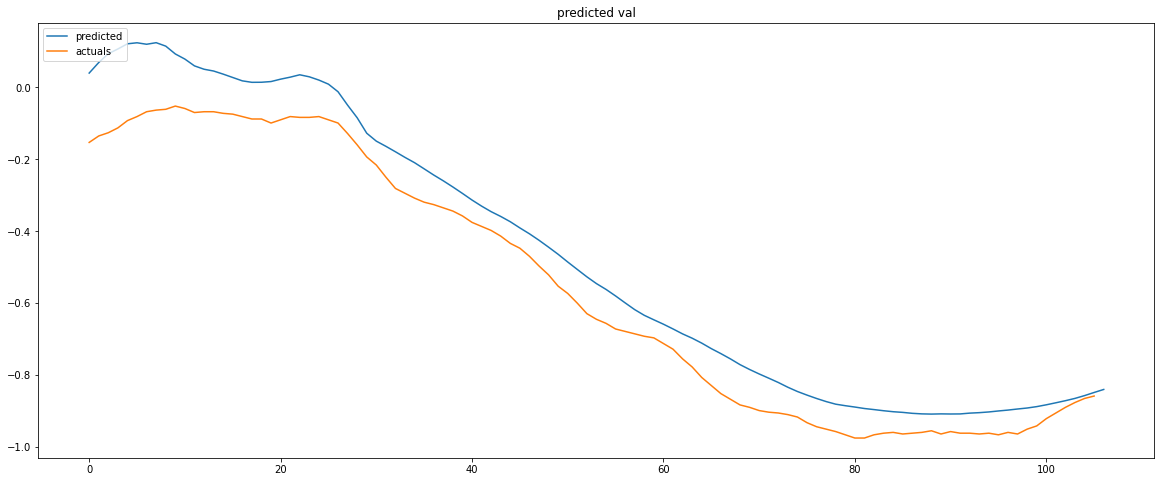

In [ ]:

plot_validation('val','covid_beds_in_use',predicted_from_cnn_val[:,0,1],multi_conv_model, CONV_WIDTH)
#plt.ylim(-1,3)

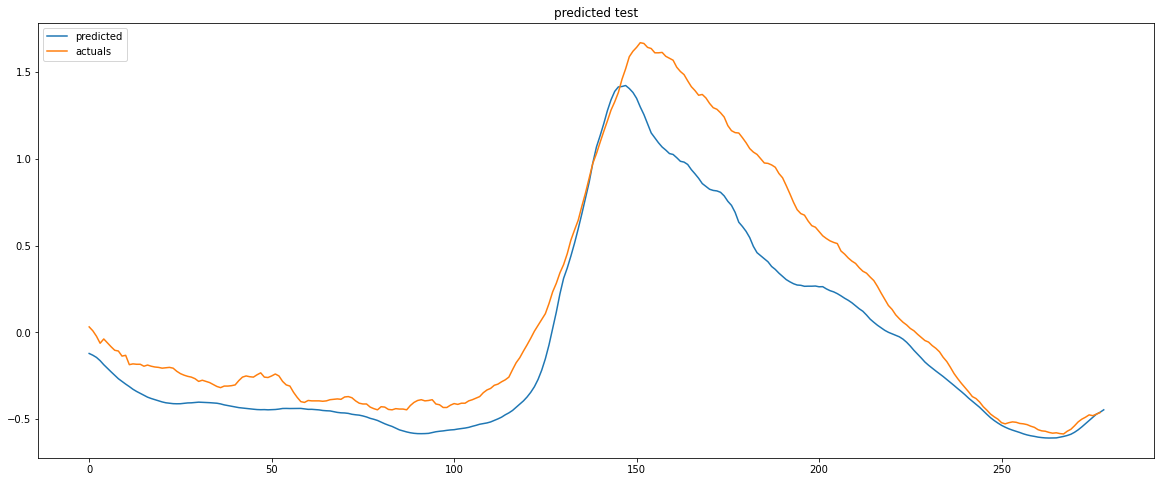

In [ ]:
# during the test period, predicted peak hosp are 
# higher than actual
plot_validation('test','covid_beds_in_use',predicted_from_cnn_test[:,0,1],multi_conv_model, CONV_WIDTH)
#plt.ylim(-1,3)

In [ ]:
column_indices

{'cli_admits': 0, 'covid_beds_in_use': 1}

(-1.0, 3.0)

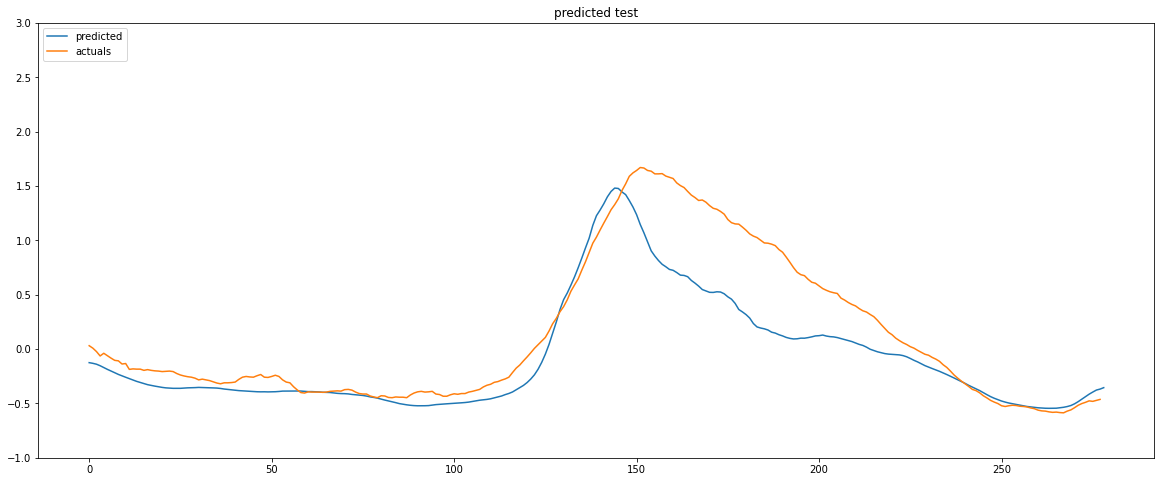

In [ ]:
plot_validation('test','covid_beds_in_use',predicted_from_cnn_test[:,0,0],multi_conv_model, CONV_WIDTH)
plt.ylim(-1,3)

#### LSTM

In [ ]:
input_shapes

((187, 1, 14, 2), (107, 1, 14, 2), (279, 1, 14, 2))

In [ ]:
predicted_from_lstm_train=predicted_from_model(train_inputs,lstm_model,(187,14,2))
predicted_from_lstm_val=predicted_from_model(val_inputs,lstm_model,(107,14,2))
predicted_from_lstm_test=predicted_from_model(test_inputs,lstm_model,(279,14,2))


predicted_from_lstm_train.shape

(187, 14, 2)

In [ ]:
column_indices

{'cli_admits': 0, 'covid_beds_in_use': 1}

In [ ]:
predicted_from_lstm_train.shape

(187, 14, 2)

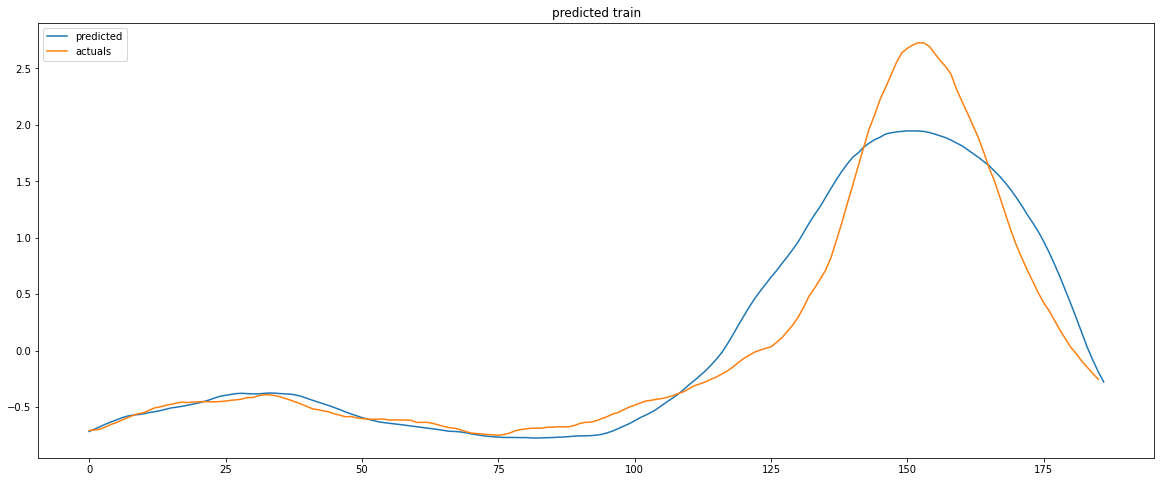

In [ ]:
plot_validation('train','covid_beds_in_use',predicted_from_lstm_train[:,0,1],lstm_model, CONV_WIDTH)

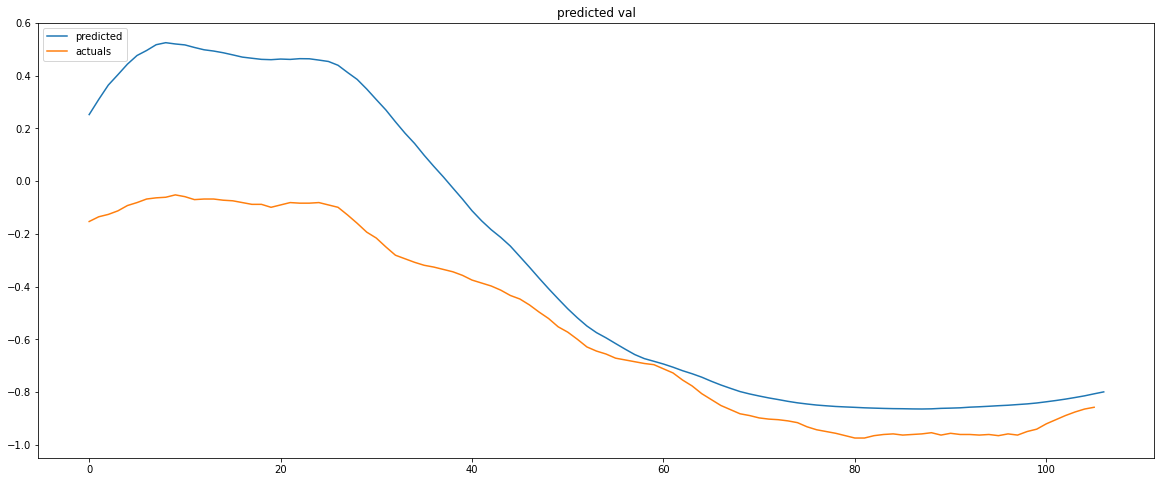

In [ ]:
plot_validation('val','covid_beds_in_use',predicted_from_lstm_val[:,0,0],lstm_model, CONV_WIDTH)
#plt.ylim(-1,3)

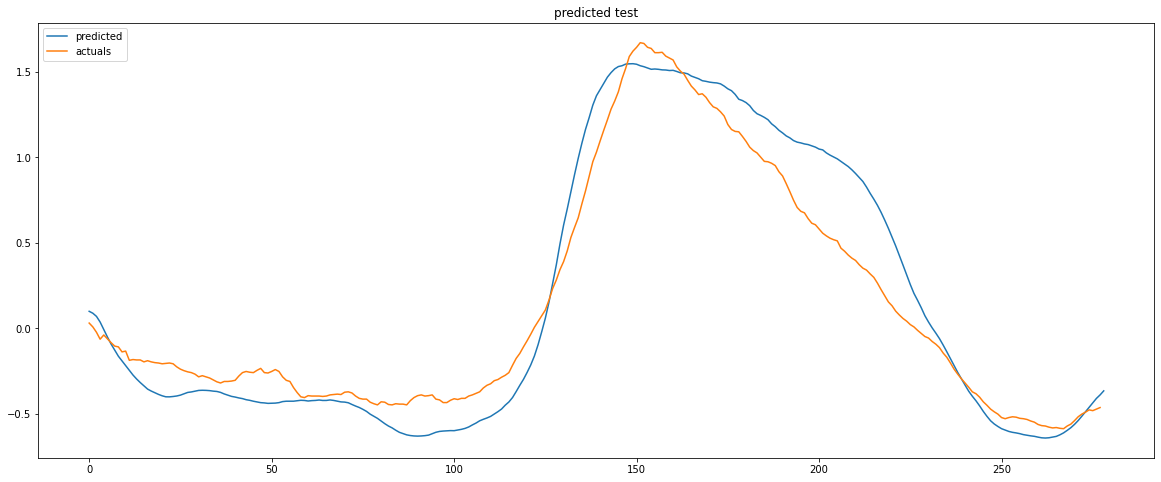

In [ ]:
plot_validation('test','covid_beds_in_use',predicted_from_lstm_test[:,0,0],lstm_model, CONV_WIDTH)
#plt.ylim(-1,3)

#### Model Outputs

In [ ]:
predicted_from_msd_train.shape

(187, 14, 2)

In [ ]:
predicted_from_linear_train.shape

(187, 14, 2)

In [ ]:
column_indices

{'cli_admits': 0, 'covid_beds_in_use': 1}

In [ ]:
temp_df=pd.DataFrame(predicted_from_linear_train[186,:,:].reshape(14,2))
temp_df.columns=['cli_admits','covid_beds_in_use']
temp_df

,cli_admits,covid_beds_in_use
0,-0.657158,-0.345764
1,-0.673086,-0.386138
2,-0.684549,-0.423992
3,-0.691418,-0.458913
4,-0.694504,-0.490438
5,-0.692478,-0.518621
6,-0.685462,-0.543424
7,-0.674428,-0.564798
8,-0.660071,-0.582758
9,-0.643911,-0.596946


In [ ]:
temp_df=pd.DataFrame(predicted_from_linear_train[186,:,:].reshape(14,2))
temp_df.columns=['cli_admits','covid_beds_in_use']
temp_df

,cli_admits,covid_beds_in_use
0,-0.657158,-0.345764
1,-0.673086,-0.386138
2,-0.684549,-0.423992
3,-0.691418,-0.458913
4,-0.694504,-0.490438
5,-0.692478,-0.518621
6,-0.685462,-0.543424
7,-0.674428,-0.564798
8,-0.660071,-0.582758
9,-0.643911,-0.596946


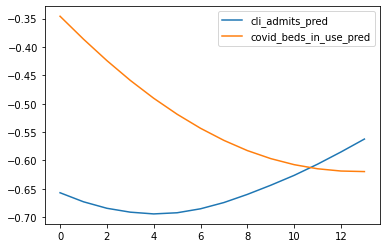

In [ ]:
plt.plot(temp_df['cli_admits'],label='cli_admits_pred')
plt.plot(temp_df['covid_beds_in_use'],label='covid_beds_in_use_pred')
plt.legend()

In [ ]:
# next weeks prediction, the last 10-day window in predicted_from_msd_train
next_week_prediction=predicted_from_msd_train[-1:,:,:].reshape(14,2)
next_week_prediction.shape

(20, 2)

In [ ]:
# next weeks prediction, the last 10-day window in predicted_from_linear_train
next_week_prediction=predicted_from_linear_train[-1:,:,:].reshape(14,2)
next_week_prediction.shape

(14, 2)

In [ ]:
pd.DataFrame(next_week_prediction)

,0,1
0,-0.657158,-0.345764
1,-0.673086,-0.386138
2,-0.684549,-0.423992
3,-0.691418,-0.458913
4,-0.694504,-0.490438
5,-0.692478,-0.518621
6,-0.685462,-0.543424
7,-0.674428,-0.564798
8,-0.660071,-0.582758
9,-0.643911,-0.596946


In [ ]:
# next weeks prediction, the last 10-day window in predicted_from_cnn_train
next_week_prediction=predicted_from_cnn_train[-1:,:,1].reshape(10)
next_week_prediction.shape

(10,)

In [ ]:
train_df.columns

Index(['cli_admits', 'covid_beds_in_use'], dtype='object')

In [ ]:
train_df.tail()

,cli_admits,covid_beds_in_use
date,,
2022-02-09,-0.543302,0.029518
2022-02-10,-0.636975,-0.026515
2022-02-11,-0.730648,-0.091513
2022-02-12,-0.707229,-0.145305
2022-02-13,-0.754066,-0.199097


In [ ]:
train_df['covid_beds_in_use'][-10:]

date
2022-02-04    0.426232
2022-02-05    0.354510
2022-02-06    0.269340
2022-02-07    0.181928
2022-02-08    0.105723
2022-02-09    0.029518
2022-02-10   -0.026515
2022-02-11   -0.091513
2022-02-12   -0.145305
2022-02-13   -0.199097
Name: covid_beds_in_use, dtype: float64

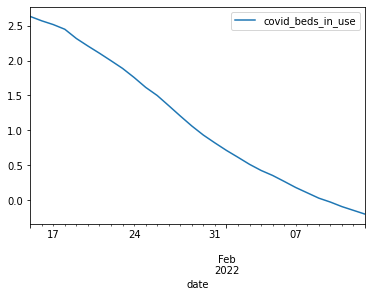

In [ ]:
train_df[-30:].plot(y='covid_beds_in_use')

In [ ]:
train_df.columns

Index(['cli_admits', 'covid_beds_in_use'], dtype='object')

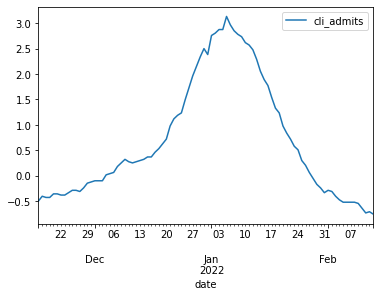

In [ ]:
train_df[-90:].plot(y='cli_admits')

In [ ]:
next_week_prediction

array([[-0.65715814, -0.34576353],
       [-0.6730864 , -0.38613805],
       [-0.684549  , -0.42399207],
       [-0.69141763, -0.45891315],
       [-0.6945044 , -0.49043828],
       [-0.6924778 , -0.5186207 ],
       [-0.68546224, -0.54342353],
       [-0.6744276 , -0.5647982 ],
       [-0.6600713 , -0.5827581 ],
       [-0.64391124, -0.5969464 ],
       [-0.62647885, -0.60761195],
       [-0.6067296 , -0.6148664 ],
       [-0.58518946, -0.61884356],
       [-0.5624303 , -0.6197974 ]], dtype=float32)

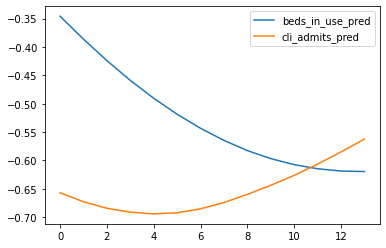

In [ ]:
next_week_df=pd.DataFrame(next_week_prediction)
next_week_df.columns={'cli_admits_pred','covid_beds_in_use_pred'}

plt.plot(next_week_df['covid_beds_in_use_pred'],label='beds_in_use_pred')
plt.plot(next_week_df['cli_admits_pred'],label='cli_admits_pred')
plt.legend()

In [ ]:
combined=train_df.append(next_week_df)
combined.tail(23)

,cli_admits,covid_beds_in_use,cli_admits_pred,covid_beds_in_use_pred
2022-02-06 00:00:00,-0.519884,0.266773,NaN,NaN
2022-02-07 00:00:00,-0.519884,0.179214,NaN,NaN
2022-02-08 00:00:00,-0.519884,0.102881,NaN,NaN
2022-02-09 00:00:00,-0.543302,0.026548,NaN,NaN
2022-02-10 00:00:00,-0.636975,-0.029579,NaN,NaN
2022-02-11 00:00:00,-0.730648,-0.094687,NaN,NaN
2022-02-12 00:00:00,-0.707229,-0.148569,NaN,NaN
2022-02-13 00:00:00,-0.754066,-0.202451,NaN,NaN
2022-02-14 00:00:00,-0.777484,-0.254088,NaN,NaN
0,NaN,NaN,-0.657158,-0.345764


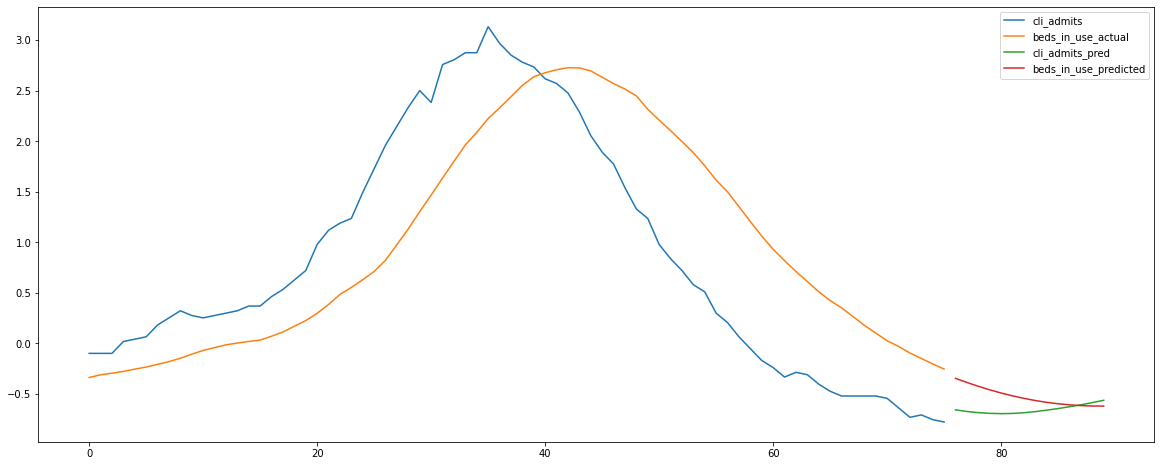

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(combined['cli_admits'][-90:].values,label='cli_admits')
plt.plot(combined['covid_beds_in_use'][-90:].values,label='beds_in_use_actual')
plt.plot(combined['cli_admits_pred'][-90:].values,label='cli_admits_pred')
plt.plot(combined['covid_beds_in_use_pred'][-90:].values,label='beds_in_use_predicted')
plt.legend()

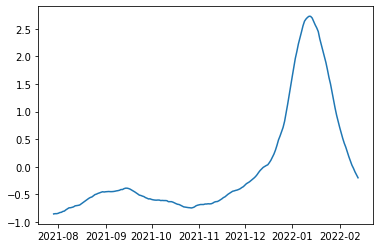

In [ ]:
plt.plot(train_df['covid_beds_in_use'])

In [ ]:
train_inputs.shape

(187, 1, 14, 2)

In [ ]:
temp_inputs=train_inputs.reshape(69,7,9)
linear_model_outputs=linear_model.predict(temp_inputs)

In [ ]:
temp_inputs=train_inputs.reshape(128,2,10)
dense_model_outputs=multi_dense_model.predict(temp_inputs)

In [ ]:
dense_model_outputs.shape

(128, 10, 1)

In [ ]:
column_indices

{'cli_admits': 0, 'covid_beds_in_use': 1}

In [ ]:
# next weeks prediction
next_week_prediction=dense_model_outputs[-1:,:7,0]
next_week_prediction.shape

NameError: ignored

In [ ]:
next_week_prediction

array([[0.9656186, 1.0029722, 1.0350232, 1.0620129, 1.0836278, 1.0996838,
        1.1099002]], dtype=float32)

In [ ]:
train_inputs.shape

(69, 9, 7, 1)

In [ ]:
train_reshaped=train_inputs.reshape(69,7,9)
feedback_model_outputs=feedback_model.predict(train_reshaped)

In [ ]:
# shape of outputs of lstm_model
# (batch, time, num_features)
feedback_model_outputs.shape

(69, 7, 9)

In [ ]:
linear_model_outputs.shape

(69, 7, 9)

In [ ]:
column_indices

{'cli_admits': 0, 'covid_beds_in_use': 1}

In [ ]:
# keep predicted hospitalizations
predicted_hospitalizations_feedback=feedback_model_outputs[:,:,1]
predicted_hospitalizations_feedback.shape

(69, 7)

In [ ]:
linear_model_outputs.shape

NameError: ignored

In [ ]:
# keep predicted hospitalizations
predicted_hospitalizations_linear=linear_model_outputs[:,:,1]
predicted_hospitalizations_linear.shape

NameError: ignored

In [ ]:
predicted_hospitalizations_df=pd.DataFrame(next_week_prediction)
predicted_hospitalizations_df.head()

,0,1,2,3,4,5,6
0,0.761318,0.765981,0.766243,0.761987,0.752303,0.737726,0.718334


In [ ]:
predicted_hospitalizations_df=pd.DataFrame(predicted_hospitalizations_feedback)
predicted_hospitalizations_df.head()

,0,1,2,3,4,5,6
0,-0.256601,-0.085118,-0.044843,-0.019237,-0.003021,0.005353,0.007961
1,-0.212750,-0.060766,-0.026335,-0.006014,0.005714,0.010677,0.010848
2,-0.189869,-0.023345,0.021838,0.046496,0.057576,0.059700,0.056221
3,-0.082182,0.061710,0.093116,0.107160,0.109928,0.105310,0.096154
4,-0.084836,0.044366,0.084171,0.102775,0.108326,0.105539,0.097619


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'linear train fitted hosp')

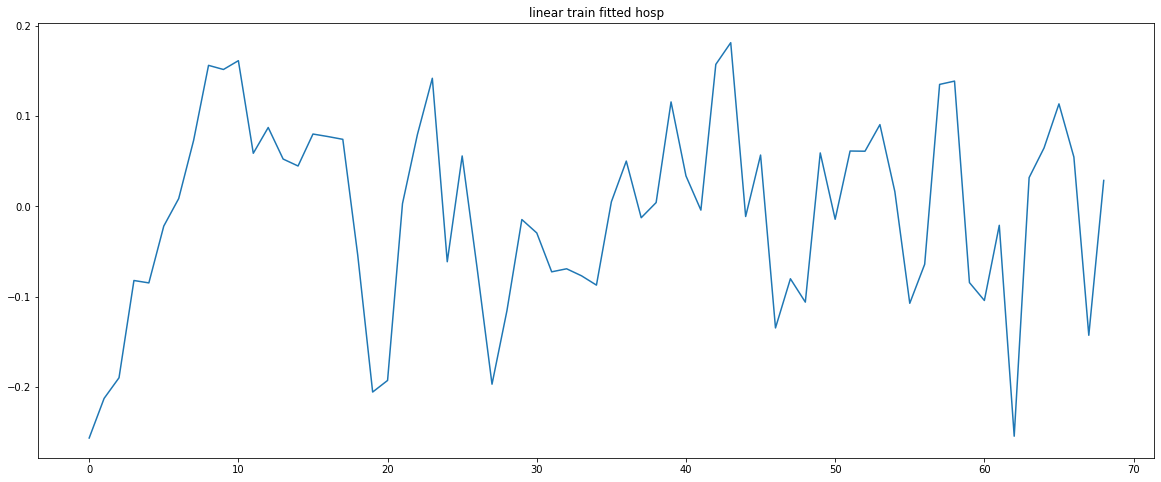

In [ ]:
predicted_hospitalizations_df=pd.DataFrame(predicted_hospitalizations_feedback)
pred_hosp_col_1=predicted_hospitalizations_df[[0]]
pred_hosp_col_1.columns=['pred_hosp']
pred_hosp_col_1['pred_hosp_7ma']=pred_hosp_col_1['pred_hosp'].rolling(7).mean()
plt.figure(figsize=(20,8))
plt.plot(pred_hosp_col_1['pred_hosp'])
plt.title('linear train fitted hosp')

In [ ]:
predicted_hospitalizations_df=pd.DataFrame(predicted_hospitalizations_linear)
pred_hosp_col_1=predicted_hospitalizations_df[[0]]
pred_hosp_col_1.columns=['pred_hosp']
pred_hosp_col_1['pred_hosp_7ma']=pred_hosp_col_1['pred_hosp'].rolling(7).mean()
plt.figure(figsize=(20,8))
plt.plot(pred_hosp_col_1['pred_hosp'])
plt.title('feedback train fitted hosp')

NameError: ignored

In [ ]:
train_df['hospitalizations_total']

185   -1.137111
6     -1.044757
211   -1.137111
7     -1.090934
8     -1.044757
         ...   
571   -0.490632
562   -0.629163
631   -0.259746
524   -0.167392
643   -0.305923
Name: hospitalizations_total, Length: 552, dtype: float64

ValueError: ignored

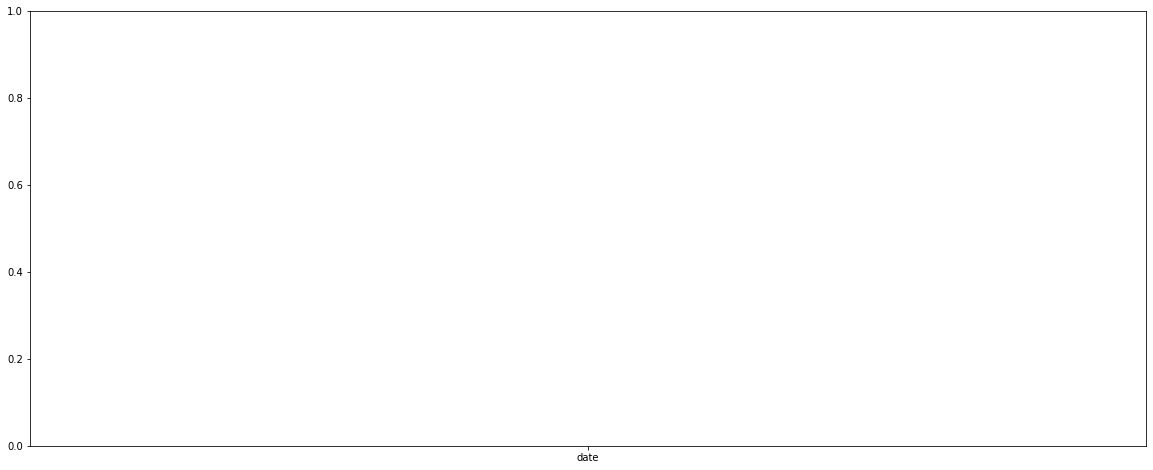

In [ ]:
plt.figure(figsize=(20,8))
plt.plot('date','hospitalizations_total',data=train_df)

#### Test Dataset Results

In [ ]:
predicted_from_linear_train.shape

(128, 10, 1)

In [ ]:
# only take the first 7 days of predicted hospitalizations
predicted_hospitalizations_df=pd.DataFrame(predicted_from_linear_train[:,:7,:].reshape(128,7))
predicted_hospitalizations_df.head()

,0,1,2,3,4,5,6
0,0.003231,0.014858,0.026492,0.038044,0.049310,0.061258,0.073293
1,-0.002169,0.009253,0.020821,0.032694,0.044625,0.057168,0.070042
2,-0.011398,-0.000990,0.009683,0.020599,0.031322,0.042703,0.054497
3,-0.018867,-0.009124,0.001194,0.011973,0.022334,0.033765,0.046066
4,-0.021559,-0.011913,-0.001809,0.008500,0.018414,0.029368,0.041069


In [ ]:
predicted_from_msd_train.shape

(128, 10, 1)

In [ ]:
column_indices

{'cases_total': 0, 'hospitalizations_total': 1}

In [ ]:
predicted_hosp=predicted_from_msd_train[:,:7,:].reshape(128,7)

predicted_hosp=(predicted_hosp*train_std[column_indices['hospitalizations_total']])+train_mean[column_indices['hospitalizations_total']]


In [ ]:
predicted_hospitalizations_df=pd.DataFrame(predicted_hosp)

predicted_hospitalizations_df

NameError: ignored

In [ ]:
predicted_hospitalizations_df=pd.DataFrame(predicted_hospitalizations_df.sum(axis='columns'))
predicted_hospitalizations_df.columns=['predicted_next7']
predicted_hospitalizations_df

,predicted_next7
0,257.674011
1,253.261139
2,248.814331
3,248.589127
4,246.758118
...,...
123,1083.257080
124,1025.342529
125,965.680542
126,907.802185


In [ ]:
combined=test_hospitalizations_df.join(predicted_hospitalizations_df)
combined.info()

NameError: ignored

In [ ]:
test_df.columns

Index(['hospitalizations_total', 'cases_total', 'cases_age_50_59',
       'cases_age_60_69', 'cases_age_70_79', 'cases_black_non_latinx',
       'cases_latinx', 'cases_white_non_latinx', 'hosp_per_case'],
      dtype='object')

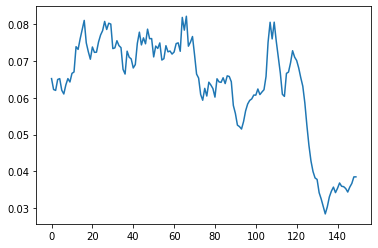

In [ ]:
plt.plot(chicago_covid[30:]['hosp_per_case'].values)

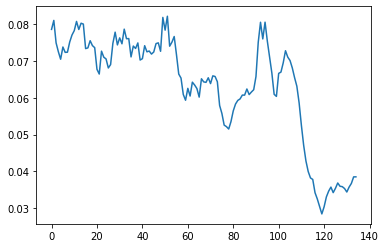

In [ ]:
plt.plot(chicago_covid[45:]['hosp_per_case'].values)

In [ ]:
plt.plot(combined['predicted'])
plt.plot(combined['weekly hospitalizations'])
plt.legend()

NameError: ignored

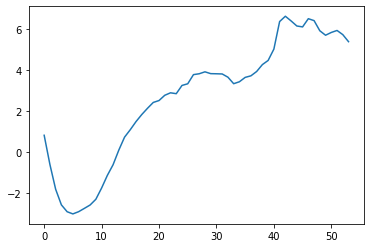

In [ ]:
plt.plot(combined['predicted'])

In [ ]:
train_std

hospitalizations_total     43.484552
cases_total               553.027916
cases_age_50_59            75.250663
cases_age_60_69            49.760556
cases_age_70_79            24.623892
cases_black_non_latinx    101.632723
cases_latinx              232.954315
dtype: float64

In [ ]:
train_mean[column_indices['hospitalizations_total']]

51.76396396396397

In [ ]:

#hospitalizations_index=column_indices['hospitalizations_total']
# (batch, ,feature)
# take only the first seven days of prediction
predicted_hosp=pd.DataFrame(dense_model_outputs[:,:5,0])
predicted_hosp.head()

NameError: ignored

In [ ]:
train_std

cases_total               585.820339
hospitalizations_total     35.212944
dtype: float64

In [ ]:
train_std[column_indices['hospitalizations_total']]

35.212944033580214

In [ ]:
predicted_hosp=(predicted_hosp*train_std[column_indices['hospitalizations_total']])+train_mean[column_indices['hospitalizations_total']]
predicted_hosp

,0,1,2,3,4
0,35.823105,35.950249,36.421700,37.250553,37.981415
1,35.360397,35.449749,35.884995,36.683880,37.384174
2,35.771660,35.903221,36.409630,37.289673,38.084579
3,35.724762,35.867413,36.369968,37.235683,38.003635
4,34.955193,35.014057,35.408157,36.171730,36.849133
...,...,...,...,...,...
136,112.830734,112.452499,112.397476,112.434494,111.546646
137,105.014542,104.985512,105.215675,105.536957,105.089828
138,97.783798,97.997101,98.405205,98.907326,98.773148
139,90.146912,90.557213,91.077866,91.693367,91.771347


In [ ]:
predicted_hosp.head(5).sum(axis='columns')/7

0    35.314335
1    35.277031
2    34.969460
3    35.193577
4    35.034386
dtype: float32

In [ ]:
temp_df=train_df[['hospitalizations_total']]
temp_df=(temp_df*train_std[column_indices['hospitalizations_total']])+train_mean[column_indices['hospitalizations_total']]

# for a given date, create a field for the next seven days hospitalizations
temp_df.sort_index(ascending=False,inplace=True)
temp_df['hosp_r7sum']=temp_df['hospitalizations_total'].rolling(7).sum()
temp_df.head(10)
temp_df.sort_index(inplace=True)

In [ ]:
temp_df.head(10)

,hospitalizations_total,hosp_r7sum
date,,
2021-09-09,36.714286,240.142857
2021-09-10,33.714286,233.285714
2021-09-11,33.571429,231.428571
2021-09-12,34.000000,228.857143
2021-09-13,36.285714,225.428571
2021-09-14,35.000000,218.000000
2021-09-15,30.857143,212.000000
2021-09-16,29.857143,211.285714
2021-09-17,31.857143,211.571429


In [ ]:
temp_df.tail(10)

,hospitalizations_total,hosp_r7sum
date,,
2022-01-14,174.714286,1044.428571
2022-01-15,167.857143,982.571429
2022-01-16,159.857143,920.714286
2022-01-17,150.142857,860.571429
2022-01-18,139.285714,NaN
2022-01-19,131.428571,NaN
2022-01-20,121.142857,NaN
2022-01-21,112.857143,NaN
2022-01-22,106.000000,NaN


In [ ]:
# the dense model tended to over predict the next seven days of hospitalizations
# (estimates were higher than actuals)
predicted_2=pd.DataFrame(predicted_hosp.sum(axis='columns'))

plt.figure(figsize=(20,5))

# plot prediction of hospitalizations (rolling sum) for the next 7 days (forward-looking, as of a given date)
plt.plot(predicted_2)

# plot 7-day rolling sum of hospitalizations
plt.plot(np.array(temp_df[:-5]['hosp_r5sum']))

plt.title('Predicted Hospitalizations (next 7 days')

# the actual peak (orange)

TypeError: ignored

In [ ]:
test_df['hospitalizations_total']

215   -0.364327
515   -0.570899
502   -0.479089
467   -0.754518
309   -0.685661
617   -0.616803
281   -0.524994
302   -0.524994
638   -0.570899
142   -0.387280
445   -0.524994
212   -0.341375
201   -0.341375
630   -0.341375
166   -0.295470
500   -0.318423
140   -0.295470
578   -0.249565
34    -0.502042
161   -0.134804
279   -0.272518
576   -0.042994
283   -0.157756
316   -0.111851
328   -0.479089
219    0.117672
347    0.553768
412    0.002911
348    0.324244
600    0.324244
292    0.370149
220    0.599672
657    0.209482
423    0.576720
610    0.484910
534    0.186530
229    0.530815
318    0.416053
128    0.439006
327    0.163577
585    0.852148
190    0.989863
538    0.989863
419    1.425958
554    1.311196
386    0.943958
558    0.989863
570    1.288243
297    1.999767
486    1.288243
553    1.448910
646    2.091576
275    1.471862
584    0.530815
195   -0.111851
86    -0.570899
350   -0.456137
173   -0.547946
492   -0.364327
519   -0.823375
Name: hospitalizations_total, dtype: flo

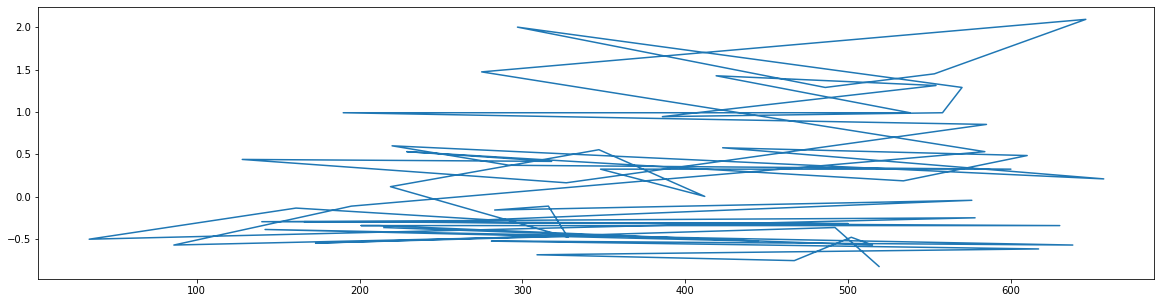

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test_df['hospitalizations_total'])